# Project 1: Yelp Business Rating Prediction using Tensorflow<a href="#Project-1:-Yelp-Business-Rating-Prediction-using-Tensorflow" class="anchor-link">¶</a>

##### Tran Ngoc Bao Huynh and Ong Thao<a href="#Tran-Ngoc-Bao-Huynh-and-Ong-Thao" class="anchor-link">¶</a>

### Imports and Helpful Functions<a href="#Imports-and-Helpful-Functions" class="anchor-link">¶</a>

In \[86\]:

    import numpy as np
    import pandas as pd
    import shutil
    import os
    import csv
    import json
    from sklearn import preprocessing
    import sklearn.feature_extraction.text as sk_text
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Activation
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.models import load_model

    # Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
    def to_xy(df, target):
        result = []
        for x in df.columns:
            if x != target:
                result.append(x)
        # find out the type of the target column. 
        target_type = df[target].dtypes
        target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
        # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
        if target_type in (np.int64, np.int32):
            # Classification
            dummies = pd.get_dummies(df[target])
            return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
        else:
            # Regression
            return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
        
    # Regression chart.
    def chart_regression(pred,y,sort=True):
        t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
        if sort:
            t.sort_values(by=['y'],inplace=True)
        a = plt.plot(t['pred'].tolist(),label='prediction',linewidth=1.0,color='g')
        b = plt.plot(t['y'].tolist(),label='expected',linewidth=2.0,color='b')
        plt.ylabel('output')
        plt.legend()
        plt.show()

## Data Preprocessing<a href="#Data-Preprocessing" class="anchor-link">¶</a>

Filtering out businesses that have less than 20 reviews and those that
are not currently open. Then writing the business data into an output
file.

We are using three different datasets:

-   Business dataset with all info.
-   Business dataset without review count included.
-   Business dataset focusing on only one business category.

### Business With All Info<a href="#Business-With-All-Info" class="anchor-link">¶</a>

In \[87\]:

    path = './yelp_dataset/'

    # create output file to store preprocessed data
    outfile_b_all = open('business_all.csv', 'w')
    bfile = csv.writer(outfile_b_all, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
    bfile.writerow(['business_id','name','business_stars','review_count','categories'])

    # filter out businesses with less than 20 reviews and those that are not open
    business_path = os.path.join(path, 'yelp_academic_dataset_business.json')
    with open(business_path, encoding='utf-8') as b:
        for line in b:
            row = json.loads(line)
            if(row['review_count'] >= 20 and row['is_open'] == 1):
                bfile.writerow([row['business_id'], row['name'], row['stars'], row['review_count'], row['categories']])
    outfile_b_all.close()

    # create dataframe for preprocessed business with all data
    df_b_all = pd.read_csv('business.csv', delimiter='\t', encoding='utf-8')
    df_b_all

Out\[87\]:

|       | business_id            | name                                   | business_stars | review_count | category                                          |
|-------|------------------------|----------------------------------------|----------------|--------------|---------------------------------------------------|
| 0     | f9NumwFMBDn751xgFiRbNA | The Range At Lake Norman               | 3.5            | 36           | Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh... |
| 1     | 51M2Kk903DFYI6gnB5I6SQ | USE MY GUY SERVICES LLC                | 4.5            | 26           | Home Services, Plumbing, Electricians, Handyma... |
| 2     | cKyLV5oWZJ2NudWgqs8VZw | Oasis Auto Center - Gilbert            | 4.5            | 38           | Auto Repair, Automotive, Oil Change Stations, ... |
| 3     | oiAlXZPIFm2nBCt0DHLu_Q | Green World Cleaners                   | 3.5            | 81           | Dry Cleaning & Laundry, Local Services, Laundr... |
| 4     | x3Po6tJGb729u_HJPY6UCA | Glendale Glitters                      | 2.5            | 52           | Arts & Entertainment, Festivals, Local Flavor     |
| ...   | ...                    | ...                                    | ...            | ...          | ...                                               |
| 54522 | n2BKYb8aw4AhRKLkdUjQRg | Steak & Cheese & Quick Pita Restaurant | 2.5            | 21           | Sandwiches, Restaurants                           |
| 54523 | YZeUH6zYS0dq5QHLYZhUnQ | Hooters                                | 2.0            | 106          | Nightlife, American (Traditional), Chicken Win... |
| 54524 | fNil19SUfPAPnLQrYnFrGQ | Cheyenne West Animal Hospital          | 4.5            | 124          | Pets, Pet Sitting, Veterinarians, Pet Services    |
| 54525 | JjcJVqhZXhP4tvOhg3fnag | Water Heater Pros                      | 5.0            | 217          | Contractors, Local Services, Appliances & Repa... |
| 54526 | SYa2j1boLF8DcGVOYfHPcA | Five Guys                              | 3.5            | 97           | American (New), Food, Burgers, Restaurants, Fa... |

54527 rows × 5 columns

### Business With No Review Count<a href="#Business-With-No-Review-Count" class="anchor-link">¶</a>

In \[88\]:

    df_b_no_rc = df_b_all.drop('review_count', axis=1)
    df_b_no_rc

Out\[88\]:

|       | business_id            | name                                   | business_stars | category                                          |
|-------|------------------------|----------------------------------------|----------------|---------------------------------------------------|
| 0     | f9NumwFMBDn751xgFiRbNA | The Range At Lake Norman               | 3.5            | Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh... |
| 1     | 51M2Kk903DFYI6gnB5I6SQ | USE MY GUY SERVICES LLC                | 4.5            | Home Services, Plumbing, Electricians, Handyma... |
| 2     | cKyLV5oWZJ2NudWgqs8VZw | Oasis Auto Center - Gilbert            | 4.5            | Auto Repair, Automotive, Oil Change Stations, ... |
| 3     | oiAlXZPIFm2nBCt0DHLu_Q | Green World Cleaners                   | 3.5            | Dry Cleaning & Laundry, Local Services, Laundr... |
| 4     | x3Po6tJGb729u_HJPY6UCA | Glendale Glitters                      | 2.5            | Arts & Entertainment, Festivals, Local Flavor     |
| ...   | ...                    | ...                                    | ...            | ...                                               |
| 54522 | n2BKYb8aw4AhRKLkdUjQRg | Steak & Cheese & Quick Pita Restaurant | 2.5            | Sandwiches, Restaurants                           |
| 54523 | YZeUH6zYS0dq5QHLYZhUnQ | Hooters                                | 2.0            | Nightlife, American (Traditional), Chicken Win... |
| 54524 | fNil19SUfPAPnLQrYnFrGQ | Cheyenne West Animal Hospital          | 4.5            | Pets, Pet Sitting, Veterinarians, Pet Services    |
| 54525 | JjcJVqhZXhP4tvOhg3fnag | Water Heater Pros                      | 5.0            | Contractors, Local Services, Appliances & Repa... |
| 54526 | SYa2j1boLF8DcGVOYfHPcA | Five Guys                              | 3.5            | American (New), Food, Burgers, Restaurants, Fa... |

54527 rows × 4 columns

### Coffee Business<a href="#Coffee-Business" class="anchor-link">¶</a>

In \[89\]:

    df_b_coffee = df_b_all[df_b_all['category'].str.contains('coffee', case=False, na=False)]
    df_b_coffee

Out\[89\]:

|       | business_id            | name                      | business_stars | review_count | category                                          |
|-------|------------------------|---------------------------|----------------|--------------|---------------------------------------------------|
| 22    | 8Hvp1tYKiQbBgGIwkCRK5g | Tony's Family Restaurant  | 4.0            | 60           | Coffee & Tea, Restaurants, Food, Breakfast & B... |
| 32    | NLaK58WvlNQdUunSIkt-jA | Zav Coffee Shop & Gallery | 4.5            | 24           | Coffee & Tea, Restaurants, Sandwiches, Food       |
| 52    | 1aVqiz43klXaFJUUx0H5fw | Dutch Bros Coffee         | 4.0            | 247          | Coffee & Tea, Food, Juice Bars & Smoothies        |
| 69    | bVXGCxKYvylArU9JkPkkRQ | Starbucks                 | 2.0            | 108          | Food, Coffee & Tea                                |
| 72    | oUX2bYbqjqST-urKbOHG6w | Loftti Cafe               | 4.5            | 284          | Sandwiches, Shaved Ice, Coffee & Tea, Desserts... |
| ...   | ...                    | ...                       | ...            | ...          | ...                                               |
| 54436 | r6bvqwhWy73SgyK_w8Y5Lg | Starbucks                 | 3.5            | 24           | Coffee & Tea, Food, Restaurants, Sandwiches       |
| 54475 | iWWzRAnDWrg1YImwTCVcWQ | Brioche à Tête            | 4.5            | 25           | Coffee & Tea, Restaurants, Bakeries, Cafes, Food  |
| 54499 | NeM7anGnTOTn7sEJavS3sw | Starbucks                 | 4.5            | 26           | Food, Coffee & Tea                                |
| 54504 | 00liP5s4IKsq97EH4Cc0Tw | Starbucks                 | 2.0            | 69           | Coffee & Tea, Food                                |
| 54520 | BtTCTHwoIfr3fBQjaOkpIw | Starbucks                 | 4.0            | 22           | Coffee & Tea, Food                                |

3020 rows × 5 columns

### Moving onto preprocessing the review datasets.<a href="#Moving-onto-preprocessing-the-review-datasets." class="anchor-link">¶</a>

In \[90\]:

    # loading review dataset
    review_path = os.path.join(path, 'yelp_academic_dataset_review.json')
    outfile_r = open('review.csv', 'w')
    rfile = csv.writer(outfile_r, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
    rfile.writerow(['business_id','review_stars','text'])

    # write each review to the outfile_r file
    with open(review_path, encoding='utf-8') as r:
        for line in r:
            row = json.loads(line)
            rfile.writerow([row['business_id'], row['stars'], row['text'].encode('utf-8')])
    outfile_r.close()

Printing out our reviews dataframe to check and see what we have so far.

In \[91\]:

    # create dataframe for review data
    df_r = pd.read_csv('review.csv', delimiter='\t', encoding='utf-8')
    df_r

Out\[91\]:

|         | business_id            | review_stars | text                                              |
|---------|------------------------|--------------|---------------------------------------------------|
| 0       | -MhfebM0QIsKt87iDN-FNw | 2.0          | b'As someone who has worked with many museums,... |
| 1       | lbrU8StCq3yDfr-QMnGrmQ | 1.0          | b'I am actually horrified this place is still ... |
| 2       | HQl28KMwrEKHqhFrrDqVNQ | 5.0          | b"I love Deagan's. I do. I really do. The atmo... |
| 3       | 5JxlZaqCnk1MnbgRirs40Q | 1.0          | b'Dismal, lukewarm, defrosted-tasting "TexMex"... |
| 4       | IS4cv902ykd8wj1TR0N3-A | 4.0          | b'Oh happy day, finally have a Canes near my c... |
| ...     | ...                    | ...          | ...                                               |
| 8021117 | XW2kaXdahICaJ27A0dhGHg | 1.0          | b"Fricken unbelievable, I ordered 2 space heat... |
| 8021118 | IsoLzudHC50oJLiEWpwV-w | 3.0          | b"Solid American food with a southern comfort ... |
| 8021119 | kDCyqlYcstqnoqnfBRS5Og | 5.0          | b"I'm honestly not sure how I have never been ... |
| 8021120 | VKVDDHKtsdrnigeIf9S8RA | 3.0          | b"Food was decent but I will say the service t... |
| 8021121 | 2SbyRgHWuWNlq18eHAx95Q | 5.0          | b"Oh yeah! Not only that the service was good,... |

8021122 rows × 3 columns

### Data Aggregation<a href="#Data-Aggregation" class="anchor-link">¶</a>

Grouping all reviews from the same business together and creating a new
dataframe that puts all of the aggregated business reviews together.

In \[92\]:

    df_review_agg = df_r.groupby('business_id')['text'].sum()
    df_all_reviews = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews':df_review_agg.values})
    df_all_reviews

Out\[92\]:

|        | business_id            | all_reviews                                        |
|--------|------------------------|----------------------------------------------------|
| 0      | --1UhMGODdWsrMastO9DZw | b'If you are looking for authentic Mexican str...  |
| 1      | --6MefnULPED_I942VcFNA | b"The bbq pork is very juicy and I only come h...  |
| 2      | --7zmmkVg-IMGaXbuVd0SQ | b"I'm a tad reluctant to write a review as I r...  |
| 3      | --8LPVSo5i0Oo61X01sV9A | b'Dr. LaCognata is great. He is a great liste...   |
| 4      | --9QQLMTbFzLJ_oT-ON3Xw | b'Always great customer service. Affordable ha...  |
| ...    | ...                    | ...                                                |
| 209388 | zzvlwkcNR1CCqOPXwuvz2A | b"I came here on a Friday night looking for a ...  |
| 209389 | zzwaS0xn1MVEPEf0hNLjew | b'Though, I never had a friend with a grandma ...  |
| 209390 | zzwhN7x37nyjP0ZM8oiHmw | b'This place is a hidden gem! The pickle fries...  |
| 209391 | zzwicjPC9g246MK2M1ZFBA | b'Food not good no selection..bad service +Qat...  |
| 209392 | zzzaIBwimxVej4tY6qFOUQ | b"Way overpriced \$35.99 Family Meal, tasteless... |

209393 rows × 2 columns

## Merging business and aggregated, business reviews dataframes together into one dataframe.<a href="#Merging-business-and-aggregated,-business-reviews-dataframes-together-into-one-dataframe." class="anchor-link">¶</a>

Renaming "stars" column to something more readable. Also, saving
preprocessed dataframe into a CSV file, so we won't have to redo the
data processing and save us time when we need to test something later.

### Merge with df_b\_all<a href="#Merge-with-df_b_all" class="anchor-link">¶</a>

In \[103\]:

    # merge the business and review data together on business_id
    df_b1 = pd.merge(df_all_reviews, df_b_all, on='business_id') 
    df_b1 = df_b1.rename(columns={'stars': 'star_rating'})
    df_b1.to_csv('Business_With_No_RC.csv', index=False)
    df_b1

Out\[103\]:

|       | business_id             | all_reviews                                       | name                          | business_stars | review_count | category                                          |
|-------|-------------------------|---------------------------------------------------|-------------------------------|----------------|--------------|---------------------------------------------------|
| 0     | --1UhMGODdWsrMastO9DZw  | b'If you are looking for authentic Mexican str... | The Spicy Amigos              | 4.0            | 27           | Restaurants, Mexican                              |
| 1     | --6MefnULPED_I942VcFNA  | b"The bbq pork is very juicy and I only come h... | John's Chinese BBQ Restaurant | 3.0            | 55           | Chinese, Restaurants                              |
| 2     | --7zmmkVg-IMGaXbuVd0SQ  | b"I'm a tad reluctant to write a review as I r... | Primal Brewery                | 4.0            | 65           | Breweries, Food                                   |
| 3     | --9e1ONYQuAa-CB_Rrw7Tw  | b"On yelp 5 stars = Woohoo! as good as it gets... | Delmonico Steakhouse          | 4.0            | 1759         | Seafood, Cajun/Creole, Restaurants, Steakhouses   |
| 4     | --DaPTJW3-tB1vP-PfdTEg  | b"I used to come to this restaurant about two ... | Sunnyside Grill               | 4.0            | 51           | Restaurants, Breakfast & Brunch                   |
| ...   | ...                     | ...                                               | ...                           | ...            | ...          | ...                                               |
| 54522 | zzmIMvqiBJ\_-wVKg_OnGpw | b"I was traveling to town for business and stu... | Gianni's Trattoria            | 4.0            | 139          | Restaurants, Italian, Food                        |
| 54523 | zzsOLFhgUw8gnjLTVVItFA  | b"I'm usually not a big fan of Mexican pastrie... | La Purisima Bakery            | 4.5            | 138          | Bakeries, Restaurants, Food                       |
| 54524 | zzwaS0xn1MVEPEf0hNLjew  | b'Though, I never had a friend with a grandma ... | Dilly Dally Lounge            | 3.5            | 73           | Nightlife, Lounges, Bars, Dive Bars               |
| 54525 | zzwhN7x37nyjP0ZM8oiHmw  | b'This place is a hidden gem! The pickle fries... | Carmody's Grille              | 4.0            | 75           | American (New), Restaurants                       |
| 54526 | zzwicjPC9g246MK2M1ZFBA  | b'Food not good no selection..bad service +Qat... | Sizzler                       | 3.0            | 81           | Buffets, Salad, American (Traditional), Seafoo... |

54527 rows × 6 columns

### Merge with df_b\_no_rc (no review count)<a href="#Merge-with-df_b_no_rc-(no-review-count)" class="anchor-link">¶</a>

In \[104\]:

    df_b2 = pd.merge(df_all_reviews, df_b_no_rc, on='business_id') 
    df_b2 = df_b2.rename(columns={'stars': 'star_rating'})
    df_b2.to_csv('Business_With_No_RC.csv', index=False)
    df_b2

Out\[104\]:

|       | business_id             | all_reviews                                       | name                          | business_stars | category                                          |
|-------|-------------------------|---------------------------------------------------|-------------------------------|----------------|---------------------------------------------------|
| 0     | --1UhMGODdWsrMastO9DZw  | b'If you are looking for authentic Mexican str... | The Spicy Amigos              | 4.0            | Restaurants, Mexican                              |
| 1     | --6MefnULPED_I942VcFNA  | b"The bbq pork is very juicy and I only come h... | John's Chinese BBQ Restaurant | 3.0            | Chinese, Restaurants                              |
| 2     | --7zmmkVg-IMGaXbuVd0SQ  | b"I'm a tad reluctant to write a review as I r... | Primal Brewery                | 4.0            | Breweries, Food                                   |
| 3     | --9e1ONYQuAa-CB_Rrw7Tw  | b"On yelp 5 stars = Woohoo! as good as it gets... | Delmonico Steakhouse          | 4.0            | Seafood, Cajun/Creole, Restaurants, Steakhouses   |
| 4     | --DaPTJW3-tB1vP-PfdTEg  | b"I used to come to this restaurant about two ... | Sunnyside Grill               | 4.0            | Restaurants, Breakfast & Brunch                   |
| ...   | ...                     | ...                                               | ...                           | ...            | ...                                               |
| 54522 | zzmIMvqiBJ\_-wVKg_OnGpw | b"I was traveling to town for business and stu... | Gianni's Trattoria            | 4.0            | Restaurants, Italian, Food                        |
| 54523 | zzsOLFhgUw8gnjLTVVItFA  | b"I'm usually not a big fan of Mexican pastrie... | La Purisima Bakery            | 4.5            | Bakeries, Restaurants, Food                       |
| 54524 | zzwaS0xn1MVEPEf0hNLjew  | b'Though, I never had a friend with a grandma ... | Dilly Dally Lounge            | 3.5            | Nightlife, Lounges, Bars, Dive Bars               |
| 54525 | zzwhN7x37nyjP0ZM8oiHmw  | b'This place is a hidden gem! The pickle fries... | Carmody's Grille              | 4.0            | American (New), Restaurants                       |
| 54526 | zzwicjPC9g246MK2M1ZFBA  | b'Food not good no selection..bad service +Qat... | Sizzler                       | 3.0            | Buffets, Salad, American (Traditional), Seafoo... |

54527 rows × 5 columns

### Merge with df_b\_coffee (coffee categories)<a href="#Merge-with-df_b_coffee-(coffee-categories)" class="anchor-link">¶</a>

In \[105\]:

    df_b3 = pd.merge(df_all_reviews, df_b_coffee, on='business_id') 
    df_b3 = df_b3.rename(columns={'stars': 'star_rating'})
    df_b1.to_csv('Coffee_Rating.csv', index=False)
    df_b3

Out\[105\]:

|      | business_id            | all_reviews                                        | name                   | business_stars | review_count | category                                          |
|------|------------------------|----------------------------------------------------|------------------------|----------------|--------------|---------------------------------------------------|
| 0    | -0RkJ_uIduNLWQrphbADRw | b"Amazing food and service. So grateful for th...  | Rooster Boy Cafe       | 4.0            | 194          | Coffee & Tea, Restaurants, Cafes, Food, Breakf... |
| 1    | -2Arz8twKJmxHMS3Sv-TeA | b'Great workers, nice sunny venue even in wint...  | Steep & Brew West      | 4.0            | 34           | Desserts, Juice Bars & Smoothies, Coffee & Tea... |
| 2    | -4TMQnQJW1yd6NqGRDvAeA | b'Great food, and perfectly portioned. Good at...  | The House Brasserie    | 4.0            | 408          | Nightlife, Burgers, Bars, Sandwiches, American... |
| 3    | -6NrhIFET7iWi4d5538fiA | b"My every Sunday stop to pickup my weekend cr...  | Spudnut Shop Donuts    | 4.0            | 38           | Restaurants, Donuts, Bakeries, Food, Coffee & Tea |
| 4    | -6l_HnrJUgk0tMPSRY7lnw | b"A new brunch spot in Markham that needs some...  | SCENIC Coffee + Brunch | 4.0            | 38           | Breakfast & Brunch, Japanese, Coffee & Tea, Fo... |
| ...  | ...                    | ...                                                | ...                    | ...            | ...          | ...                                               |
| 3015 | zu5dqKqPjJCycS5k-92Alg | b"Haven't had bubble waffles for awhile so dec...  | Chaplus                | 3.0            | 29           | Waffles, Tea Rooms, Restaurants, Coffee & Tea,... |
| 3016 | zv89ihIoUTzHo1eTAAwgvA | b"The coffee here is phenomenal, I can't start...  | Dunkin'                | 4.0            | 54           | Coffee & Tea, Donuts, Food                        |
| 3017 | zx_j6OuuHHa2afVoAZuLpA | b'My friend lives in Las Vegas but I\\'m from L... | what's Crepe           | 4.5            | 184          | Creperies, Desserts, Food, Restaurants, Acai B... |
| 3018 | zyJWc8oW8JpPg2xXMQsnAA | b'Crappy service, mediocre food. They last str...  | McDonald's             | 2.0            | 30           | Burgers, Restaurants, Fast Food, Coffee & Tea,... |
| 3019 | zzZfgEpwrpi4Ywdaj3OIuQ | b"It was my first visit and it was a Saturday....  | Adesso Cafe            | 5.0            | 30           | Coffee & Tea, Cafes, Food, Restaurants            |

3020 rows × 6 columns

## TF-IDF Vectorizer<a href="#TF-IDF-Vectorizer" class="anchor-link">¶</a>

Fitting vectorizer to all the reviews in each of the three dataframes.

### Vectorize and Prep Matrix Data<a href="#Vectorize-and-Prep-Matrix-Data" class="anchor-link">¶</a>

#### For df_b1<a href="#For-df_b1" class="anchor-link">¶</a>

In \[106\]:

    vectorizer = sk_text.TfidfVectorizer(min_df=2, max_df=.95, max_features=5000)

    review_matrix_b1 = vectorizer.fit_transform(df_b1['all_reviews'])
    tfidf_data_1 = review_matrix_b1.toarray()
    tfidf_data_1

Out\[106\]:

    array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
            0.        ],
           [0.02061719, 0.        , 0.        , ..., 0.00837175, 0.        ,
            0.        ],
           [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
            0.        ],
           ...,
           [0.00535897, 0.        , 0.        , ..., 0.01088023, 0.        ,
            0.        ],
           [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
            0.27995235],
           [0.00707675, 0.        , 0.        , ..., 0.        , 0.        ,
            0.        ]])

#### For df_b2<a href="#For-df_b2" class="anchor-link">¶</a>

In \[107\]:

    review_matrix_b2 = vectorizer.fit_transform(df_b2['all_reviews'])
    tfidf_data_2 = review_matrix_b2.toarray()
    tfidf_data_2

Out\[107\]:

    array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
            0.        ],
           [0.02061719, 0.        , 0.        , ..., 0.00837175, 0.        ,
            0.        ],
           [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
            0.        ],
           ...,
           [0.00535897, 0.        , 0.        , ..., 0.01088023, 0.        ,
            0.        ],
           [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
            0.27995235],
           [0.00707675, 0.        , 0.        , ..., 0.        , 0.        ,
            0.        ]])

#### For df_b3<a href="#For-df_b3" class="anchor-link">¶</a>

In \[108\]:

    review_matrix_b3 = vectorizer.fit_transform(df_b3['all_reviews'])
    tfidf_data_3 = review_matrix_b3.toarray()
    tfidf_data_3

Out\[108\]:

    array([[0.00243545, 0.        , 0.00902083, ..., 0.0027725 , 0.        ,
            0.00489846],
           [0.        , 0.        , 0.03391381, ..., 0.        , 0.        ,
            0.        ],
           [0.00819469, 0.        , 0.01327938, ..., 0.        , 0.        ,
            0.00412053],
           ...,
           [0.00278723, 0.        , 0.00688253, ..., 0.        , 0.        ,
            0.        ],
           [0.        , 0.        , 0.01943706, ..., 0.        , 0.        ,
            0.        ],
           [0.02328276, 0.        , 0.        , ..., 0.        , 0.        ,
            0.        ]])

### Converting numpy arrays into dataframes<a href="#Converting-numpy-arrays-into-dataframes" class="anchor-link">¶</a>

#### tfidf_data_1<a href="#tfidf_data_1" class="anchor-link">¶</a>

In \[109\]:

    tfdata_1 = pd.DataFrame(tfidf_data_1, columns=vectorizer.get_feature_names()) 
    tfdata_1

Out\[109\]:

|       | 00       | 00pm     | 10       | 100      | 10am     | 10pm     | 11       | 11am     | 11pm     | 12  | ... | yours    | yourself | yuck     | yum     | yummy    | yup      | yuzu     | zero     | zone | zucchini |
|-------|----------|----------|----------|----------|----------|----------|----------|----------|----------|-----|-----|----------|----------|----------|---------|----------|----------|----------|----------|------|----------|
| 0     | 0.000000 | 0.000000 | 0.000000 | 0.007143 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.022386 | 0.0 | ... | 0.000000 | 0.000000 | 0.010209 | 0.00000 | 0.000000 | 0.000000 | 0.012464 | 0.000000 | 0.0  | 0.000000 |
| 1     | 0.020617 | 0.000000 | 0.000000 | 0.011099 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.013044 | 0.0 | ... | 0.000000 | 0.000000 | 0.000000 | 0.00000 | 0.005654 | 0.000000 | 0.000000 | 0.008372 | 0.0  | 0.000000 |
| 2     | 0.000000 | 0.000000 | 0.000000 | 0.010412 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0 | ... | 0.015773 | 0.008742 | 0.004960 | 0.00000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| 3     | 0.004575 | 0.000899 | 0.001629 | 0.010996 | 0.008041 | 0.001616 | 0.000000 | 0.001241 | 0.004307 | 0.0 | ... | 0.001832 | 0.000831 | 0.004715 | 0.00032 | 0.009411 | 0.012707 | 0.001151 | 0.000000 | 0.0  | 0.000000 |
| 4     | 0.000000 | 0.000000 | 0.000000 | 0.027415 | 0.000000 | 0.000000 | 0.016957 | 0.000000 | 0.008592 | 0.0 | ... | 0.000000 | 0.000000 | 0.000000 | 0.00000 | 0.000000 | 0.009318 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| ...   | ...      | ...      | ...      | ...      | ...      | ...      | ...      | ...      | ...      | ... | ... | ...      | ...      | ...      | ...     | ...      | ...      | ...      | ...      | ...  | ...      |
| 54522 | 0.003095 | 0.000000 | 0.000000 | 0.016662 | 0.006216 | 0.000000 | 0.000000 | 0.000000 | 0.003264 | 0.0 | ... | 0.000000 | 0.005246 | 0.008930 | 0.00000 | 0.008488 | 0.010619 | 0.000000 | 0.000000 | 0.0  | 0.006684 |
| 54523 | 0.000000 | 0.000000 | 0.000000 | 0.014065 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0 | ... | 0.005326 | 0.000000 | 0.002513 | 0.00000 | 0.000000 | 0.014939 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| 54524 | 0.005359 | 0.000000 | 0.000000 | 0.010819 | 0.010763 | 0.000000 | 0.000000 | 0.000000 | 0.005651 | 0.0 | ... | 0.010925 | 0.000000 | 0.005154 | 0.00000 | 0.000000 | 0.000000 | 0.000000 | 0.010880 | 0.0  | 0.000000 |
| 54525 | 0.000000 | 0.000000 | 0.000000 | 0.012461 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0 | ... | 0.006292 | 0.000000 | 0.000000 | 0.00000 | 0.000000 | 0.007059 | 0.000000 | 0.000000 | 0.0  | 0.279952 |
| 54526 | 0.007077 | 0.000000 | 0.000000 | 0.026192 | 0.000000 | 0.006998 | 0.000000 | 0.006717 | 0.003731 | 0.0 | ... | 0.007214 | 0.000000 | 0.010209 | 0.00000 | 0.004852 | 0.008093 | 0.004155 | 0.000000 | 0.0  | 0.000000 |

54527 rows × 5000 columns

#### tfidf_data_2<a href="#tfidf_data_2" class="anchor-link">¶</a>

In \[110\]:

    tfdata_2 = pd.DataFrame(tfidf_data_2, columns=vectorizer.get_feature_names()) 
    tfdata_2

Out\[110\]:

|       | 00       | 00pm     | 10       | 100      | 10am     | 10pm     | 11       | 11am     | 11pm     | 12  | ... | yours    | yourself | yuck     | yum     | yummy    | yup      | yuzu     | zero     | zone | zucchini |
|-------|----------|----------|----------|----------|----------|----------|----------|----------|----------|-----|-----|----------|----------|----------|---------|----------|----------|----------|----------|------|----------|
| 0     | 0.000000 | 0.000000 | 0.000000 | 0.007143 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.022386 | 0.0 | ... | 0.000000 | 0.000000 | 0.010209 | 0.00000 | 0.000000 | 0.000000 | 0.012464 | 0.000000 | 0.0  | 0.000000 |
| 1     | 0.020617 | 0.000000 | 0.000000 | 0.011099 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.013044 | 0.0 | ... | 0.000000 | 0.000000 | 0.000000 | 0.00000 | 0.005654 | 0.000000 | 0.000000 | 0.008372 | 0.0  | 0.000000 |
| 2     | 0.000000 | 0.000000 | 0.000000 | 0.010412 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0 | ... | 0.015773 | 0.008742 | 0.004960 | 0.00000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| 3     | 0.004575 | 0.000899 | 0.001629 | 0.010996 | 0.008041 | 0.001616 | 0.000000 | 0.001241 | 0.004307 | 0.0 | ... | 0.001832 | 0.000831 | 0.004715 | 0.00032 | 0.009411 | 0.012707 | 0.001151 | 0.000000 | 0.0  | 0.000000 |
| 4     | 0.000000 | 0.000000 | 0.000000 | 0.027415 | 0.000000 | 0.000000 | 0.016957 | 0.000000 | 0.008592 | 0.0 | ... | 0.000000 | 0.000000 | 0.000000 | 0.00000 | 0.000000 | 0.009318 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| ...   | ...      | ...      | ...      | ...      | ...      | ...      | ...      | ...      | ...      | ... | ... | ...      | ...      | ...      | ...     | ...      | ...      | ...      | ...      | ...  | ...      |
| 54522 | 0.003095 | 0.000000 | 0.000000 | 0.016662 | 0.006216 | 0.000000 | 0.000000 | 0.000000 | 0.003264 | 0.0 | ... | 0.000000 | 0.005246 | 0.008930 | 0.00000 | 0.008488 | 0.010619 | 0.000000 | 0.000000 | 0.0  | 0.006684 |
| 54523 | 0.000000 | 0.000000 | 0.000000 | 0.014065 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0 | ... | 0.005326 | 0.000000 | 0.002513 | 0.00000 | 0.000000 | 0.014939 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| 54524 | 0.005359 | 0.000000 | 0.000000 | 0.010819 | 0.010763 | 0.000000 | 0.000000 | 0.000000 | 0.005651 | 0.0 | ... | 0.010925 | 0.000000 | 0.005154 | 0.00000 | 0.000000 | 0.000000 | 0.000000 | 0.010880 | 0.0  | 0.000000 |
| 54525 | 0.000000 | 0.000000 | 0.000000 | 0.012461 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0 | ... | 0.006292 | 0.000000 | 0.000000 | 0.00000 | 0.000000 | 0.007059 | 0.000000 | 0.000000 | 0.0  | 0.279952 |
| 54526 | 0.007077 | 0.000000 | 0.000000 | 0.026192 | 0.000000 | 0.006998 | 0.000000 | 0.006717 | 0.003731 | 0.0 | ... | 0.007214 | 0.000000 | 0.010209 | 0.00000 | 0.004852 | 0.008093 | 0.004155 | 0.000000 | 0.0  | 0.000000 |

54527 rows × 5000 columns

#### tfidf_data_3<a href="#tfidf_data_3" class="anchor-link">¶</a>

In \[111\]:

    tfdata_3 = pd.DataFrame(tfidf_data_3, columns=vectorizer.get_feature_names()) 
    tfdata_3

Out\[111\]:

|      | 00       | 00pm | 10       | 100      | 10am     | 10pm     | 11       | 11am     | 11pm | 12       | ... | yours | yourself | yuck     | yum      | yummy    | yup      | yuzu     | zero     | zone | zucchini |
|------|----------|------|----------|----------|----------|----------|----------|----------|------|----------|-----|-------|----------|----------|----------|----------|----------|----------|----------|------|----------|
| 0    | 0.002435 | 0.0  | 0.009021 | 0.005074 | 0.004082 | 0.000000 | 0.009725 | 0.004119 | 0.0  | 0.002267 | ... | 0.0   | 0.016974 | 0.000000 | 0.002565 | 0.009887 | 0.000000 | 0.000000 | 0.002773 | 0.0  | 0.004898 |
| 1    | 0.000000 | 0.0  | 0.033914 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.034091 | ... | 0.0   | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| 2    | 0.008195 | 0.0  | 0.013279 | 0.003201 | 0.000000 | 0.000000 | 0.001023 | 0.000000 | 0.0  | 0.006674 | ... | 0.0   | 0.004462 | 0.001782 | 0.005394 | 0.014970 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.004121 |
| 3    | 0.000000 | 0.0  | 0.005470 | 0.027689 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.000000 | ... | 0.0   | 0.000000 | 0.000000 | 0.000000 | 0.021582 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| 4    | 0.005480 | 0.0  | 0.001692 | 0.000000 | 0.009186 | 0.000000 | 0.000000 | 0.004634 | 0.0  | 0.000000 | ... | 0.0   | 0.000000 | 0.000000 | 0.000000 | 0.004450 | 0.005373 | 0.260892 | 0.000000 | 0.0  | 0.000000 |
| ...  | ...      | ...  | ...      | ...      | ...      | ...      | ...      | ...      | ...  | ...      | ... | ...   | ...      | ...      | ...      | ...      | ...      | ...      | ...      | ...  | ...      |
| 3015 | 0.000000 | 0.0  | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.000000 | ... | 0.0   | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| 3016 | 0.000000 | 0.0  | 0.006907 | 0.000000 | 0.018755 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.010415 | ... | 0.0   | 0.000000 | 0.000000 | 0.011785 | 0.009085 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| 3017 | 0.002787 | 0.0  | 0.006883 | 0.000000 | 0.000000 | 0.004793 | 0.000000 | 0.000000 | 0.0  | 0.000000 | ... | 0.0   | 0.001214 | 0.000000 | 0.010274 | 0.013578 | 0.000000 | 0.015610 | 0.000000 | 0.0  | 0.000000 |
| 3018 | 0.000000 | 0.0  | 0.019437 | 0.000000 | 0.000000 | 0.027072 | 0.000000 | 0.000000 | 0.0  | 0.000000 | ... | 0.0   | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.030868 | 0.000000 | 0.000000 | 0.0  | 0.000000 |
| 3019 | 0.023283 | 0.0  | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.000000 | ... | 0.0   | 0.020284 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.0  | 0.000000 |

3020 rows × 5000 columns

### Ready Training Data<a href="#Ready-Training-Data" class="anchor-link">¶</a>

Concatenating the star rating column to the vectorized dataframes and
saving all of the dataframes.

In \[115\]:

    train1 = pd.concat([df_b1[['review_count','business_stars']], tfdata_1] , axis=1)
    train1.to_csv('training_1.csv')

    train2 = pd.concat([df_b2['business_stars'], tfdata_2] , axis=1)
    train2.to_csv('training_2.csv')

    train3 = pd.concat([df_b3['business_stars'], tfdata_3] , axis=1)
    train3.to_csv('training_3.csv')

## Split Training and Test Data<a href="#Split-Training-and-Test-Data" class="anchor-link">¶</a>

In \[116\]:

    # train1 split
    x,y = to_xy(train1,'business_stars')
    x1_train, x1_test, y1_train, y1_test = train_test_split(x, y, test_size=0.3, random_state=19)

    # train2 split
    x,y = to_xy(train2,'business_stars')
    x2_train, x2_test, y2_train, y2_test = train_test_split(x, y, test_size=0.3, random_state=19)

    # train3 split
    x,y = to_xy(train3,'business_stars')
    x3_train, x3_test, y3_train, y3_test = train_test_split(x, y, test_size=0.3, random_state=19)

## Neural Network Models<a href="#Neural-Network-Models" class="anchor-link">¶</a>

For our case, because we are dealing with three different dataframes, we
are going to test all of the neural network models on the dataframe with
all the reviews first. Then afterwards, we will use the best model to
train our other two dataframes and determine how more focused data and
less columns affect the training model's performance.

### Neural Network \#1:<a href="#Neural-Network-#1:" class="anchor-link">¶</a>

-   Input layer: 5000 neurons
-   6 layers, 4 hidden layers (40, 20, 15, and 5 neurons respectively)
-   Activation function: relu
-   Optimizer: Adam

In \[117\]:

    # Save best model with best weights
    checkpointer = ModelCheckpoint(filepath="best_adam_relu_model.hdf5", verbose=0, save_best_only=True)

    # Run model training three times to jump out of local optimum 
    for i in range(3):
        print('\nRun: ', i + 1)
        
        relu_model = Sequential()

        relu_model.add(Dense(40, input_dim=x1_train.shape[1], activation='relu'))
        relu_model.add(Dense(20, activation='relu'))
        relu_model.add(Dense(15, activation = 'relu'))
        relu_model.add(Dense(5, activation='relu'))
        
        # ouput layer
        relu_model.add(Dense(1))

        # Use MSE loss since it is a regression problem
        relu_model.compile(loss='mean_squared_error', optimizer='adam')

        # Stop training when model stops improving
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')
                                                    
        relu_model.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), 
                       callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

    Run:  1
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 15s - loss: 1.7823 - val_loss: 0.1810
    Epoch 2/1000
    38168/38168 - 13s - loss: 0.1917 - val_loss: 0.1227
    Epoch 3/1000
    38168/38168 - 14s - loss: 0.1985 - val_loss: 0.1076
    Epoch 4/1000
    38168/38168 - 14s - loss: 0.1631 - val_loss: 0.1012
    Epoch 5/1000
    38168/38168 - 14s - loss: 0.1012 - val_loss: 0.2899
    Epoch 6/1000
    38168/38168 - 14s - loss: 0.0881 - val_loss: 0.4961
    Epoch 7/1000
    38168/38168 - 14s - loss: 0.0998 - val_loss: 0.0801
    Epoch 8/1000
    38168/38168 - 14s - loss: 0.0895 - val_loss: 0.0874
    Epoch 9/1000
    38168/38168 - 14s - loss: 0.0889 - val_loss: 0.0812
    Epoch 10/1000
    38168/38168 - 14s - loss: 0.0679 - val_loss: 0.0712
    Epoch 11/1000
    38168/38168 - 27s - loss: 0.0680 - val_loss: 0.0896
    Epoch 12/1000
    38168/38168 - 27s - loss: 0.0792 - val_loss: 0.0734
    Epoch 13/1000
    38168/38168 - 15s - loss: 0.0561 - val_loss: 0.1362
    Epoch 00013: early stopping

    Run:  2
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 16s - loss: 10.1888 - val_loss: 7.0543
    Epoch 2/1000
    38168/38168 - 14s - loss: 4.9501 - val_loss: 3.2217
    Epoch 3/1000
    38168/38168 - 15s - loss: 2.1700 - val_loss: 1.3968
    Epoch 4/1000
    38168/38168 - 13s - loss: 1.0076 - val_loss: 0.7972
    Epoch 5/1000
    38168/38168 - 13s - loss: 0.7064 - val_loss: 0.7074
    Epoch 6/1000
    38168/38168 - 24s - loss: 0.6744 - val_loss: 0.7050
    Epoch 7/1000
    38168/38168 - 20s - loss: 0.6736 - val_loss: 0.7050
    Epoch 8/1000
    38168/38168 - 22s - loss: 0.6737 - val_loss: 0.7053
    Epoch 9/1000
    38168/38168 - 14s - loss: 0.6737 - val_loss: 0.7049
    Epoch 00009: early stopping

    Run:  3
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 17s - loss: 1.8748 - val_loss: 0.1307
    Epoch 2/1000
    38168/38168 - 14s - loss: 0.1613 - val_loss: 0.1063
    Epoch 3/1000
    38168/38168 - 14s - loss: 0.1188 - val_loss: 0.1027
    Epoch 4/1000
    38168/38168 - 14s - loss: 0.1061 - val_loss: 0.1509
    Epoch 5/1000
    38168/38168 - 13s - loss: 0.1753 - val_loss: 0.0891
    Epoch 6/1000
    38168/38168 - 14s - loss: 0.0900 - val_loss: 0.0807
    Epoch 7/1000
    38168/38168 - 14s - loss: 0.1114 - val_loss: 0.1693
    Epoch 8/1000
    38168/38168 - 14s - loss: 0.0869 - val_loss: 0.3026
    Epoch 9/1000
    38168/38168 - 14s - loss: 0.0758 - val_loss: 0.2448
    Epoch 00009: early stopping

### Network \#1 - RSME Score<a href="#Network-#1---RSME-Score" class="anchor-link">¶</a>

In \[118\]:

    saved_a_relu_model = load_model("best_adam_relu_model.hdf5")

    # Adam Relu Model Prediction and MSE
    relu_model_pred = saved_a_relu_model.predict(x1_test)
    a_relu_model_rmse = np.sqrt(metrics.mean_squared_error(relu_model_pred, y1_test))
    print(f'Adam Relu Model RMSE: {a_relu_model_rmse}')

    Adam Relu Model RMSE: 0.2668260633945465

### Network \#1 - Prediction<a href="#Network-#1---Prediction" class="anchor-link">¶</a>

In \[119\]:

    # print out prediction
    df_y = pd.DataFrame(y1_test, columns=['business_stars'])
    df_pred = pd.DataFrame(relu_model_pred, columns=['predicted'])
    result = pd.concat([df_y, df_pred],axis=1)
    result

Out\[119\]:

|       | business_stars | predicted |
|-------|----------------|-----------|
| 0     | 3.0            | 3.645131  |
| 1     | 3.0            | 3.233371  |
| 2     | 5.0            | 4.723314  |
| 3     | 4.0            | 3.597445  |
| 4     | 3.5            | 3.188206  |
| ...   | ...            | ...       |
| 16354 | 4.5            | 4.806306  |
| 16355 | 4.0            | 3.755446  |
| 16356 | 2.5            | 2.538314  |
| 16357 | 2.5            | 2.871856  |
| 16358 | 4.0            | 4.131235  |

16359 rows × 2 columns

### Network \#1 - Lift Chart<a href="#Network-#1---Lift-Chart" class="anchor-link">¶</a>

In \[120\]:

    plt.rcParams['figure.figsize'] = [10, 10]
    chart_regression(relu_model_pred.flatten(), y1_test, sort=True)

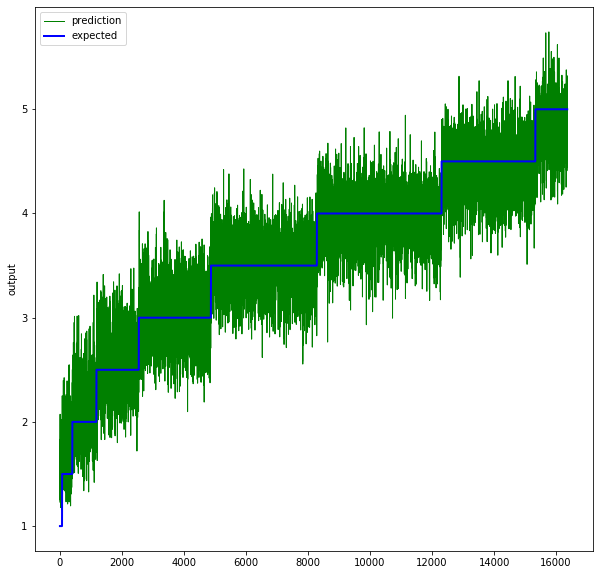

### Neural Network \#2:<a href="#Neural-Network-#2:" class="anchor-link">¶</a>

-   Input layer: 5000 neurons
-   6 layers, 4 hidden layers (40, 20, 15, and 5 neurons respectively)
-   Activation function: sigmoid
-   Optimizer: adam

In \[121\]:

    # Save best model with best weights
    checkpointer = ModelCheckpoint(filepath="best_adam_sigmoid_model.hdf5", verbose=0, save_best_only=True)

    # Run model training three times to jump out of local optimum
    for i in range(3):
        print('\nRun: ', i + 1)

        sigmoid_model = Sequential()

        sigmoid_model.add(Dense(40, input_dim=x1_train.shape[1], activation='sigmoid'))
        sigmoid_model.add(Dense(20, activation='sigmoid'))
        sigmoid_model.add(Dense(15, activation='sigmoid'))
        sigmoid_model.add(Dense(5, activation='sigmoid'))

        sigmoid_model.add(Dense(1))

        # Use MSE loss since it is a regression problem
        sigmoid_model.compile(loss='mean_squared_error', optimizer='adam')

        # Stop training when model stops improving
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

        sigmoid_model.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), 
                          callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

    Run:  1
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 14s - loss: 1.9066 - val_loss: 0.7052
    Epoch 2/1000
    38168/38168 - 13s - loss: 0.6737 - val_loss: 0.7051
    Epoch 3/1000
    38168/38168 - 14s - loss: 0.6737 - val_loss: 0.7048
    Epoch 4/1000
    38168/38168 - 19s - loss: 0.4814 - val_loss: 0.1550
    Epoch 5/1000
    38168/38168 - 31s - loss: 0.0980 - val_loss: 0.0791
    Epoch 6/1000
    38168/38168 - 21s - loss: 0.0727 - val_loss: 0.0783
    Epoch 7/1000
    38168/38168 - 15s - loss: 0.0653 - val_loss: 0.0696
    Epoch 8/1000
    38168/38168 - 19s - loss: 0.0639 - val_loss: 0.0676
    Epoch 9/1000
    38168/38168 - 21s - loss: 0.0601 - val_loss: 0.0717
    Epoch 10/1000
    38168/38168 - 23s - loss: 0.0582 - val_loss: 0.0669
    Epoch 11/1000
    38168/38168 - 15s - loss: 0.0563 - val_loss: 0.0758
    Epoch 12/1000
    38168/38168 - 15s - loss: 0.0553 - val_loss: 0.0694
    Epoch 13/1000
    38168/38168 - 16s - loss: 0.0533 - val_loss: 0.0700
    Epoch 00013: early stopping

    Run:  2
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 21s - loss: 6.8524 - val_loss: 2.5344
    Epoch 2/1000
    38168/38168 - 13s - loss: 1.3511 - val_loss: 0.7973
    Epoch 3/1000
    38168/38168 - 20s - loss: 0.6955 - val_loss: 0.7050
    Epoch 4/1000
    38168/38168 - 19s - loss: 0.6737 - val_loss: 0.7050
    Epoch 5/1000
    38168/38168 - 19s - loss: 0.6737 - val_loss: 0.7050
    Epoch 6/1000
    38168/38168 - 15s - loss: 0.6737 - val_loss: 0.7049
    Epoch 00006: early stopping

    Run:  3
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 21s - loss: 3.7347 - val_loss: 0.7456
    Epoch 2/1000
    38168/38168 - 14s - loss: 0.6790 - val_loss: 0.7050
    Epoch 3/1000
    38168/38168 - 18s - loss: 0.6737 - val_loss: 0.7051
    Epoch 4/1000
    38168/38168 - 23s - loss: 0.6738 - val_loss: 0.7049
    Epoch 5/1000
    38168/38168 - 21s - loss: 0.6384 - val_loss: 0.2514
    Epoch 6/1000
    38168/38168 - 24s - loss: 0.1238 - val_loss: 0.0848
    Epoch 7/1000
    38168/38168 - 24s - loss: 0.0757 - val_loss: 0.0711
    Epoch 8/1000
    38168/38168 - 15s - loss: 0.0680 - val_loss: 0.0706
    Epoch 9/1000
    38168/38168 - 14s - loss: 0.0649 - val_loss: 0.0694
    Epoch 10/1000
    38168/38168 - 20s - loss: 0.0605 - val_loss: 0.0664
    Epoch 11/1000
    38168/38168 - 15s - loss: 0.0594 - val_loss: 0.0667
    Epoch 12/1000
    38168/38168 - 13s - loss: 0.0586 - val_loss: 0.0669
    Epoch 13/1000
    38168/38168 - 13s - loss: 0.0558 - val_loss: 0.0738
    Epoch 00013: early stopping

### Network \#2 - RSME Score<a href="#Network-#2---RSME-Score" class="anchor-link">¶</a>

In \[122\]:

    saved_a_sigmoid_model = load_model("best_adam_sigmoid_model.hdf5")

    # Adam Sigmoid Model Prediction and MSE
    sigmoid_model_pred = saved_a_sigmoid_model.predict(x1_test)
    a_sigmoid_model_rmse = np.sqrt(metrics.mean_squared_error(sigmoid_model_pred, y1_test))
    print(f'Adam Sigmoid Model RMSE: {a_sigmoid_model_rmse}')

    Adam Sigmoid Model RMSE: 0.25774839520454407

### Network \#2 - Prediction<a href="#Network-#2---Prediction" class="anchor-link">¶</a>

In \[123\]:

    # print out prediction
    df_y = pd.DataFrame(y1_test, columns=['business_stars'])
    df_pred = pd.DataFrame(sigmoid_model_pred, columns=['predicted'])
    result = pd.concat([df_y, df_pred],axis=1)
    result

Out\[123\]:

|       | business_stars | predicted |
|-------|----------------|-----------|
| 0     | 3.0            | 3.647281  |
| 1     | 3.0            | 3.195397  |
| 2     | 5.0            | 4.778433  |
| 3     | 4.0            | 3.823741  |
| 4     | 3.5            | 3.094774  |
| ...   | ...            | ...       |
| 16354 | 4.5            | 4.754410  |
| 16355 | 4.0            | 3.921970  |
| 16356 | 2.5            | 2.516021  |
| 16357 | 2.5            | 2.796308  |
| 16358 | 4.0            | 4.179022  |

16359 rows × 2 columns

### Network \#2 - Left Chart<a href="#Network-#2---Left-Chart" class="anchor-link">¶</a>

In \[124\]:

    plt.rcParams['figure.figsize'] = [10, 10]
    chart_regression(sigmoid_model_pred.flatten(), y1_test, sort=True)

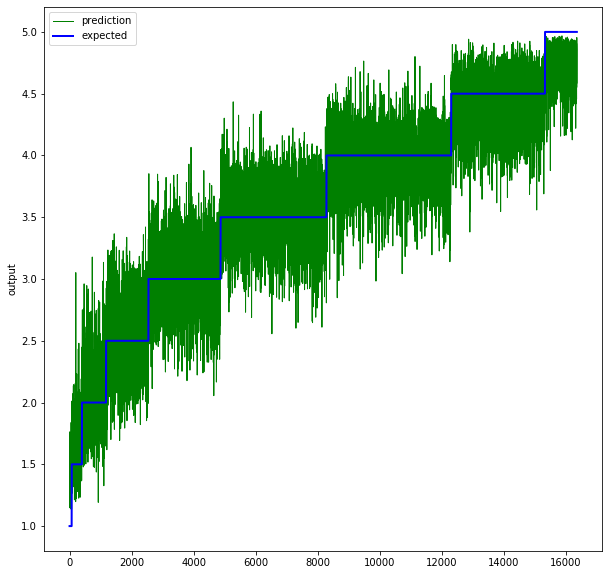

### Neural Network \#3:<a href="#Neural-Network-#3:" class="anchor-link">¶</a>

-   Input layer: 5000 neurons
-   6 layers, 4 hidden layers (40, 20, 15, and 5 neurons respectively)
-   Activation function: tanh
-   Optimizer: adam

In \[125\]:

    checkpointer = ModelCheckpoint(filepath="best_adam_tanh_model.hdf5", verbose=0, save_best_only=True)

    # Run model training three times to jump out of local optimum
    for i in range(3):
        print('\nRun: ', i + 1)

        tanh_model = Sequential()

        tanh_model.add(Dense(40, input_dim=x1_train.shape[1], activation='tanh'))
        tanh_model.add(Dense(20, activation='tanh'))
        tanh_model.add(Dense(15, activation='tanh'))
        tanh_model.add(Dense(5 , activation='tanh'))

        tanh_model.add(Dense(1))

        # Use MSE loss since it is a regression problem
        tanh_model.compile(loss='mean_squared_error', optimizer='adam')

        # Stop training when model stops improving
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

        tanh_model.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), 
                       callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

    Run:  1
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 16s - loss: 0.3869 - val_loss: 0.0891
    Epoch 2/1000
    38168/38168 - 17s - loss: 0.0882 - val_loss: 0.0828
    Epoch 3/1000
    38168/38168 - 16s - loss: 0.0744 - val_loss: 0.0742
    Epoch 4/1000
    38168/38168 - 20s - loss: 0.0646 - val_loss: 0.0859
    Epoch 5/1000
    38168/38168 - 17s - loss: 0.0635 - val_loss: 0.0770
    Epoch 6/1000
    38168/38168 - 14s - loss: 0.0605 - val_loss: 0.0709
    Epoch 7/1000
    38168/38168 - 14s - loss: 0.0604 - val_loss: 0.0716
    Epoch 8/1000
    38168/38168 - 14s - loss: 0.0547 - val_loss: 0.0803
    Epoch 9/1000
    38168/38168 - 15s - loss: 0.0574 - val_loss: 0.0950
    Epoch 00009: early stopping

    Run:  2
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 19s - loss: 1.1554 - val_loss: 0.7018
    Epoch 2/1000
    38168/38168 - 24s - loss: 0.2078 - val_loss: 0.0920
    Epoch 3/1000
    38168/38168 - 21s - loss: 0.0817 - val_loss: 0.0716
    Epoch 4/1000
    38168/38168 - 20s - loss: 0.0707 - val_loss: 0.0730
    Epoch 5/1000
    38168/38168 - 18s - loss: 0.0643 - val_loss: 0.1252
    Epoch 6/1000
    38168/38168 - 15s - loss: 0.0616 - val_loss: 0.0864
    Epoch 00006: early stopping

    Run:  3
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 16s - loss: 0.8890 - val_loss: 0.2259
    Epoch 2/1000
    38168/38168 - 14s - loss: 0.1169 - val_loss: 0.0812
    Epoch 3/1000
    38168/38168 - 14s - loss: 0.0752 - val_loss: 0.0789
    Epoch 4/1000
    38168/38168 - 14s - loss: 0.0705 - val_loss: 0.0718
    Epoch 5/1000
    38168/38168 - 14s - loss: 0.0659 - val_loss: 0.1087
    Epoch 6/1000
    38168/38168 - 14s - loss: 0.0644 - val_loss: 0.0778
    Epoch 7/1000
    38168/38168 - 14s - loss: 0.0583 - val_loss: 0.0781
    Epoch 00007: early stopping

### Network \#3 - RSME Score<a href="#Network-#3---RSME-Score" class="anchor-link">¶</a>

In \[126\]:

    saved_a_tanh_model = load_model("best_adam_tanh_model.hdf5")

    # Adam Tanh Model Prediction and MSE
    tanh_model_pred = saved_a_tanh_model.predict(x1_test)
    a_tanh_model_rmse = np.sqrt(metrics.mean_squared_error(tanh_model_pred, y1_test))
    print(f'Adam Tanh Model RMSE: {a_tanh_model_rmse}')

    Adam Tanh Model RMSE: 0.2662501931190491

### Network \#3 - Prediction<a href="#Network-#3---Prediction" class="anchor-link">¶</a>

In \[127\]:

    # print out prediction
    df_y = pd.DataFrame(y1_test, columns=['business_stars'])
    df_pred = pd.DataFrame(tanh_model_pred, columns=['predicted'])
    result = pd.concat([df_y, df_pred],axis=1)
    result

Out\[127\]:

|       | business_stars | predicted |
|-------|----------------|-----------|
| 0     | 3.0            | 3.601950  |
| 1     | 3.0            | 3.221380  |
| 2     | 5.0            | 4.777379  |
| 3     | 4.0            | 3.640136  |
| 4     | 3.5            | 3.112072  |
| ...   | ...            | ...       |
| 16354 | 4.5            | 4.603488  |
| 16355 | 4.0            | 3.743290  |
| 16356 | 2.5            | 2.440500  |
| 16357 | 2.5            | 3.011892  |
| 16358 | 4.0            | 4.132927  |

16359 rows × 2 columns

### Network \#3 - Left Chart<a href="#Network-#3---Left-Chart" class="anchor-link">¶</a>

In \[128\]:

    plt.rcParams['figure.figsize'] = [10, 10]
    chart_regression(tanh_model_pred.flatten(), y1_test, sort=True)

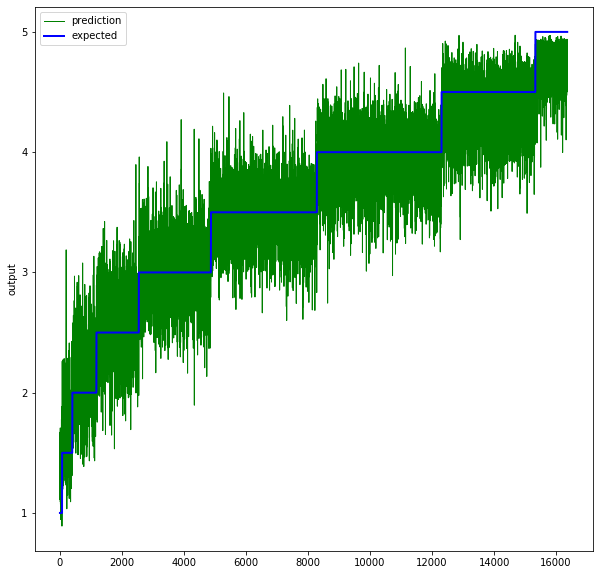

### Neural Network \#4:<a href="#Neural-Network-#4:" class="anchor-link">¶</a>

-   Input layer: 5000 neurons
-   6 layers, 4 hidden layers (40, 20, 15, and 5 neurons respectively)
-   Activation function: relu
-   Optimizer: sgd

In \[129\]:

    # Save best model with best weights
    checkpointer = ModelCheckpoint(filepath="best_sgd_relu_model.hdf5", verbose=0, save_best_only=True)

    # Run model training three times to jump out of local optimum 
    for i in range(3):
        print('\nRun: ', i + 1)
        
        relu_model = Sequential()

        relu_model.add(Dense(40, input_dim=x1_train.shape[1], activation='relu'))
        relu_model.add(Dense(20, activation='relu'))
        relu_model.add(Dense(15, activation = 'relu'))
        relu_model.add(Dense(5, activation='relu'))
        
        # ouput layer
        relu_model.add(Dense(1))

        # Use MSE loss since it is a regression problem
        relu_model.compile(loss='mean_squared_error', optimizer='sgd')

        # Stop training when model stops improving
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')
                                                    
        relu_model.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), 
                       callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

    Run:  1
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 11s - loss: nan - val_loss: nan
    Epoch 2/1000
    38168/38168 - 8s - loss: nan - val_loss: nan
    Epoch 3/1000
    38168/38168 - 9s - loss: nan - val_loss: nan
    Epoch 00003: early stopping

    Run:  2
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 11s - loss: nan - val_loss: nan
    Epoch 2/1000
    38168/38168 - 9s - loss: nan - val_loss: nan
    Epoch 3/1000
    38168/38168 - 9s - loss: nan - val_loss: nan
    Epoch 00003: early stopping

    Run:  3
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 10s - loss: 95.1492 - val_loss: 0.7049
    Epoch 2/1000
    38168/38168 - 12s - loss: 0.6741 - val_loss: 0.7056
    Epoch 3/1000
    38168/38168 - 10s - loss: 0.6739 - val_loss: 0.7049
    Epoch 4/1000
    38168/38168 - 17s - loss: 0.6740 - val_loss: 0.7050
    Epoch 00004: early stopping

### Network \#4 - RSME Score<a href="#Network-#4---RSME-Score" class="anchor-link">¶</a>

In \[130\]:

    saved_s_relu_model = load_model("best_sgd_relu_model.hdf5")

    # SGD Relu Model Prediction and MSE
    relu_model_pred = saved_s_relu_model.predict(x1_test)
    s_relu_model_rmse = np.sqrt(metrics.mean_squared_error(relu_model_pred, y1_test))
    print(f'SGD Relu Model RMSE: {s_relu_model_rmse}')

    SGD Relu Model RMSE: 0.8395958542823792

### Network \#4 - Prediction<a href="#Network-#4---Prediction" class="anchor-link">¶</a>

In \[131\]:

    # print out prediction
    df_y = pd.DataFrame(y1_test, columns=['business_stars'])
    df_pred = pd.DataFrame(relu_model_pred, columns=['predicted'])
    result = pd.concat([df_y, df_pred],axis=1)
    result

Out\[131\]:

|       | business_stars | predicted |
|-------|----------------|-----------|
| 0     | 3.0            | 3.627614  |
| 1     | 3.0            | 3.627614  |
| 2     | 5.0            | 3.627614  |
| 3     | 4.0            | 3.627614  |
| 4     | 3.5            | 3.627614  |
| ...   | ...            | ...       |
| 16354 | 4.5            | 3.627614  |
| 16355 | 4.0            | 3.627614  |
| 16356 | 2.5            | 3.627614  |
| 16357 | 2.5            | 3.627614  |
| 16358 | 4.0            | 3.627614  |

16359 rows × 2 columns

### Network \#4 - Left Chart<a href="#Network-#4---Left-Chart" class="anchor-link">¶</a>

In \[132\]:

    plt.rcParams['figure.figsize'] = [10, 10]
    chart_regression(relu_model_pred.flatten(), y1_test, sort=True)

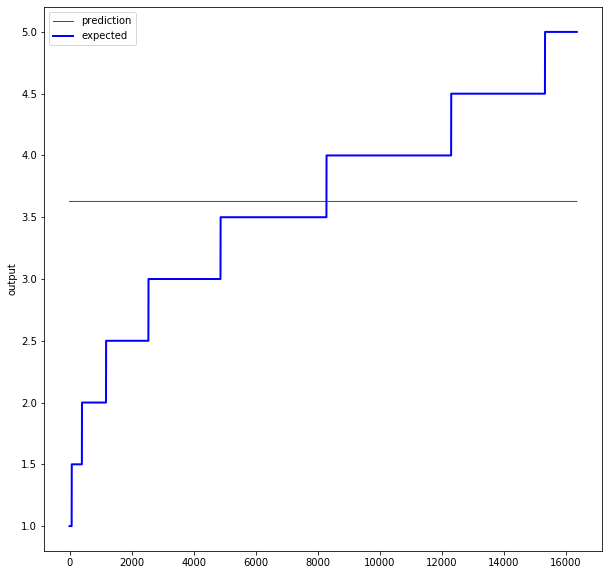

### Neural Network \#5:<a href="#Neural-Network-#5:" class="anchor-link">¶</a>

-   Input layer: 5000 neurons
-   6 layers, 4 hidden layers (40, 20, 15, and 5 neurons respectively)
-   Activation function: sigmoid
-   Optimizer: sgd

In \[133\]:

    # Save best model with best weights
    checkpointer = ModelCheckpoint(filepath="best_sgd_sigmoid_model.hdf5", verbose=0, save_best_only=True)

    # Run model training three times to jump out of local optimum 
    for i in range(3):
        print('\nRun: ', i + 1)
        
        sigmoid_model = Sequential()

        sigmoid_model.add(Dense(40, input_dim=x1_train.shape[1], activation='sigmoid'))
        sigmoid_model.add(Dense(20, activation='sigmoid'))
        sigmoid_model.add(Dense(15, activation = 'sigmoid'))
        sigmoid_model.add(Dense(5, activation='sigmoid'))
        
        # ouput layer
        sigmoid_model.add(Dense(1))

        # Use MSE loss since it is a regression problem
        sigmoid_model.compile(loss='mean_squared_error', optimizer='sgd')

        # Stop training when model stops improving
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')
                                                    
        sigmoid_model.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), 
                          callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

    Run:  1
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 11s - loss: 0.7750 - val_loss: 0.7025
    Epoch 2/1000
    38168/38168 - 11s - loss: 0.6686 - val_loss: 0.6990
    Epoch 3/1000
    38168/38168 - 9s - loss: 0.6681 - val_loss: 0.6981
    Epoch 4/1000
    38168/38168 - 8s - loss: 0.6678 - val_loss: 0.6972
    Epoch 5/1000
    38168/38168 - 8s - loss: 0.6673 - val_loss: 0.6984
    Epoch 6/1000
    38168/38168 - 8s - loss: 0.6667 - val_loss: 0.6958
    Epoch 7/1000
    38168/38168 - 8s - loss: 0.6668 - val_loss: 0.6956
    Epoch 8/1000
    38168/38168 - 8s - loss: 0.6666 - val_loss: 0.6950
    Epoch 9/1000
    38168/38168 - 8s - loss: 0.6663 - val_loss: 0.6960
    Epoch 10/1000
    38168/38168 - 8s - loss: 0.6656 - val_loss: 0.7012
    Epoch 11/1000
    38168/38168 - 8s - loss: 0.6658 - val_loss: 0.6945
    Epoch 12/1000
    38168/38168 - 8s - loss: 0.6654 - val_loss: 0.6947
    Epoch 13/1000
    38168/38168 - 8s - loss: 0.6653 - val_loss: 0.6950
    Epoch 14/1000
    38168/38168 - 9s - loss: 0.6652 - val_loss: 0.6934
    Epoch 15/1000
    38168/38168 - 8s - loss: 0.6650 - val_loss: 0.6930
    Epoch 16/1000
    38168/38168 - 11s - loss: 0.6647 - val_loss: 0.6936
    Epoch 17/1000
    38168/38168 - 16s - loss: 0.6644 - val_loss: 0.6933
    Epoch 18/1000
    38168/38168 - 9s - loss: 0.6643 - val_loss: 0.6929
    Epoch 00018: early stopping

    Run:  2
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 10s - loss: 0.7568 - val_loss: 0.7012
    Epoch 2/1000
    38168/38168 - 9s - loss: 0.6709 - val_loss: 0.7012
    Epoch 3/1000
    38168/38168 - 9s - loss: 0.6705 - val_loss: 0.7039
    Epoch 4/1000
    38168/38168 - 9s - loss: 0.6702 - val_loss: 0.7001
    Epoch 5/1000
    38168/38168 - 9s - loss: 0.6694 - val_loss: 0.7000
    Epoch 6/1000
    38168/38168 - 9s - loss: 0.6692 - val_loss: 0.6986
    Epoch 7/1000
    38168/38168 - 8s - loss: 0.6687 - val_loss: 0.7050
    Epoch 8/1000
    38168/38168 - 8s - loss: 0.6683 - val_loss: 0.6975
    Epoch 9/1000
    38168/38168 - 8s - loss: 0.6676 - val_loss: 0.6969
    Epoch 10/1000
    38168/38168 - 9s - loss: 0.6670 - val_loss: 0.6981
    Epoch 11/1000
    38168/38168 - 9s - loss: 0.6670 - val_loss: 0.6957
    Epoch 12/1000
    38168/38168 - 8s - loss: 0.6666 - val_loss: 0.6953
    Epoch 13/1000
    38168/38168 - 9s - loss: 0.6659 - val_loss: 0.6949
    Epoch 14/1000
    38168/38168 - 9s - loss: 0.6659 - val_loss: 0.6951
    Epoch 15/1000
    38168/38168 - 10s - loss: 0.6657 - val_loss: 0.6953
    Epoch 16/1000
    38168/38168 - 9s - loss: 0.6649 - val_loss: 0.7000
    Epoch 00016: early stopping

    Run:  3
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 10s - loss: 0.7616 - val_loss: 0.7005
    Epoch 2/1000
    38168/38168 - 8s - loss: 0.6701 - val_loss: 0.6994
    Epoch 3/1000
    38168/38168 - 9s - loss: 0.6693 - val_loss: 0.6988
    Epoch 4/1000
    38168/38168 - 9s - loss: 0.6689 - val_loss: 0.6982
    Epoch 5/1000
    38168/38168 - 9s - loss: 0.6685 - val_loss: 0.6997
    Epoch 6/1000
    38168/38168 - 11s - loss: 0.6681 - val_loss: 0.6969
    Epoch 7/1000
    38168/38168 - 10s - loss: 0.6675 - val_loss: 0.6964
    Epoch 8/1000
    38168/38168 - 9s - loss: 0.6671 - val_loss: 0.6958
    Epoch 9/1000
    38168/38168 - 8s - loss: 0.6664 - val_loss: 0.6956
    Epoch 10/1000
    38168/38168 - 10s - loss: 0.6666 - val_loss: 0.6951
    Epoch 11/1000
    38168/38168 - 10s - loss: 0.6659 - val_loss: 0.6944
    Epoch 12/1000
    38168/38168 - 8s - loss: 0.6657 - val_loss: 0.6953
    Epoch 13/1000
    38168/38168 - 9s - loss: 0.6655 - val_loss: 0.6939
    Epoch 14/1000
    38168/38168 - 10s - loss: 0.6653 - val_loss: 0.6941
    Epoch 15/1000
    38168/38168 - 9s - loss: 0.6651 - val_loss: 0.6927
    Epoch 16/1000
    38168/38168 - 8s - loss: 0.6648 - val_loss: 0.6928
    Epoch 17/1000
    38168/38168 - 8s - loss: 0.6648 - val_loss: 0.6922
    Epoch 18/1000
    38168/38168 - 9s - loss: 0.6642 - val_loss: 0.6918
    Epoch 19/1000
    38168/38168 - 9s - loss: 0.6641 - val_loss: 0.6925
    Epoch 20/1000
    38168/38168 - 9s - loss: 0.6638 - val_loss: 0.6927
    Epoch 21/1000
    38168/38168 - 8s - loss: 0.6634 - val_loss: 0.6916
    Epoch 22/1000
    38168/38168 - 8s - loss: 0.6628 - val_loss: 0.6911
    Epoch 23/1000
    38168/38168 - 9s - loss: 0.6621 - val_loss: 0.6980
    Epoch 24/1000
    38168/38168 - 9s - loss: 0.6624 - val_loss: 0.6900
    Epoch 25/1000
    38168/38168 - 9s - loss: 0.6617 - val_loss: 0.6942
    Epoch 26/1000
    38168/38168 - 9s - loss: 0.6607 - val_loss: 0.6880
    Epoch 27/1000
    38168/38168 - 14s - loss: 0.6604 - val_loss: 0.6869
    Epoch 28/1000
    38168/38168 - 8s - loss: 0.6597 - val_loss: 0.6856
    Epoch 29/1000
    38168/38168 - 10s - loss: 0.6591 - val_loss: 0.6946
    Epoch 30/1000
    38168/38168 - 9s - loss: 0.6581 - val_loss: 0.6836
    Epoch 31/1000
    38168/38168 - 10s - loss: 0.6570 - val_loss: 0.6847
    Epoch 32/1000
    38168/38168 - 10s - loss: 0.6558 - val_loss: 0.6871
    Epoch 33/1000
    38168/38168 - 10s - loss: 0.6537 - val_loss: 0.6791
    Epoch 34/1000
    38168/38168 - 8s - loss: 0.6520 - val_loss: 0.6781
    Epoch 35/1000
    38168/38168 - 8s - loss: 0.6500 - val_loss: 0.6724
    Epoch 36/1000
    38168/38168 - 8s - loss: 0.6474 - val_loss: 0.6652
    Epoch 37/1000
    38168/38168 - 9s - loss: 0.6433 - val_loss: 0.6593
    Epoch 38/1000
    38168/38168 - 9s - loss: 0.6404 - val_loss: 0.6589
    Epoch 39/1000
    38168/38168 - 9s - loss: 0.6376 - val_loss: 0.6498
    Epoch 40/1000
    38168/38168 - 8s - loss: 0.6337 - val_loss: 0.6540
    Epoch 41/1000
    38168/38168 - 8s - loss: 0.6297 - val_loss: 0.7508
    Epoch 42/1000
    38168/38168 - 9s - loss: 0.6240 - val_loss: 0.6544
    Epoch 00042: early stopping

### Network \#5 - RSME Score<a href="#Network-#5---RSME-Score" class="anchor-link">¶</a>

In \[134\]:

    saved_s_sigmoid_model = load_model("best_sgd_sigmoid_model.hdf5")

    # SGD Sigmoid Model Prediction and MSE
    sigmoid_model_pred = saved_s_sigmoid_model.predict(x1_test)
    s_sigmoid_model_rmse = np.sqrt(metrics.mean_squared_error(sigmoid_model_pred, y1_test))
    print(f'SGD Sigmoid Model RMSE: {s_sigmoid_model_rmse}')

    SGD Sigmoid Model RMSE: 0.8061142563819885

### Network \#5 - Prediction<a href="#Network-#5---Prediction" class="anchor-link">¶</a>

In \[135\]:

    # print out prediction
    df_y = pd.DataFrame(y1_test, columns=['business_stars'])
    df_pred = pd.DataFrame(sigmoid_model_pred, columns=['predicted'])
    result = pd.concat([df_y, df_pred],axis=1)
    result

Out\[135\]:

|       | business_stars | predicted |
|-------|----------------|-----------|
| 0     | 3.0            | 3.535585  |
| 1     | 3.0            | 3.637920  |
| 2     | 5.0            | 3.552245  |
| 3     | 4.0            | 3.577080  |
| 4     | 3.5            | 3.478475  |
| ...   | ...            | ...       |
| 16354 | 4.5            | 3.575405  |
| 16355 | 4.0            | 3.520622  |
| 16356 | 2.5            | 3.418802  |
| 16357 | 2.5            | 3.503552  |
| 16358 | 4.0            | 3.523203  |

16359 rows × 2 columns

### Network \#5 - Left Chart<a href="#Network-#5---Left-Chart" class="anchor-link">¶</a>

In \[136\]:

    plt.rcParams['figure.figsize'] = [10, 10]
    chart_regression(sigmoid_model_pred.flatten(), y1_test, sort=True)

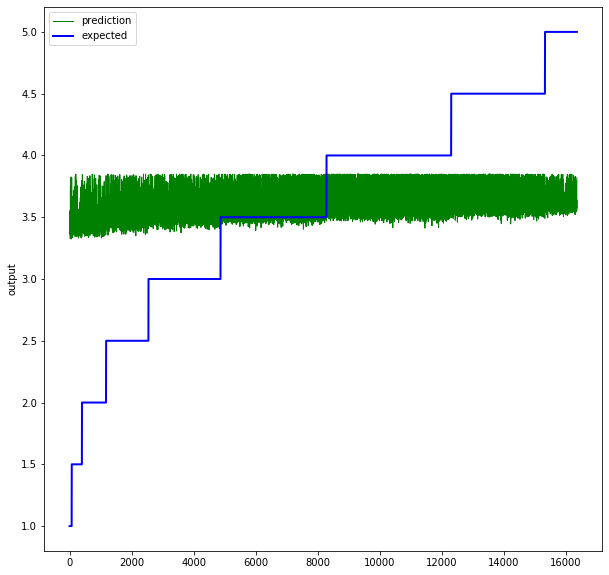

### Neural Network \#6:<a href="#Neural-Network-#6:" class="anchor-link">¶</a>

-   Input layer: 5000 neurons
-   6 layers, 4 hidden layers (40, 20, 15, and 5 neurons respectively)
-   Activation function: tanh
-   Optimizer: sgd

In \[137\]:

    # Save best model with best weights
    checkpointer = ModelCheckpoint(filepath="best_sgd_tanh_model.hdf5", verbose=0, save_best_only=True)

    # Run model training three times to jump out of local optimum 
    for i in range(3):
        print('\nRun: ', i + 1)
        
        tanh_model = Sequential()

        tanh_model.add(Dense(40, input_dim=x1_train.shape[1], activation='tanh'))
        tanh_model.add(Dense(20, activation='tanh'))
        tanh_model.add(Dense(15, activation = 'tanh'))
        tanh_model.add(Dense(5, activation='tanh'))
        
        # ouput layer
        tanh_model.add(Dense(1))

        # Use MSE loss since it is a regression problem
        tanh_model.compile(loss='mean_squared_error', optimizer='sgd')

        # Stop training when model stops improving
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')
                                                    
        tanh_model.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), 
                       callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

    Run:  1
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 10s - loss: 0.6960 - val_loss: 0.6999
    Epoch 2/1000
    38168/38168 - 9s - loss: 0.6716 - val_loss: 0.7007
    Epoch 3/1000
    38168/38168 - 8s - loss: 0.6715 - val_loss: 0.7056
    Epoch 4/1000
    38168/38168 - 9s - loss: 0.6707 - val_loss: 0.6977
    Epoch 5/1000
    38168/38168 - 11s - loss: 0.6724 - val_loss: 0.7172
    Epoch 6/1000
    38168/38168 - 9s - loss: 0.6736 - val_loss: 0.7085
    Epoch 7/1000
    38168/38168 - 9s - loss: 0.6739 - val_loss: 0.7041
    Epoch 00007: early stopping

    Run:  2
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 10s - loss: 0.6992 - val_loss: 0.6991
    Epoch 2/1000
    38168/38168 - 10s - loss: 0.6704 - val_loss: 0.7037
    Epoch 3/1000
    38168/38168 - 9s - loss: 0.6721 - val_loss: 0.7064
    Epoch 4/1000
    38168/38168 - 8s - loss: 0.6750 - val_loss: 0.7051
    Epoch 00004: early stopping

    Run:  3
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 10s - loss: 0.7040 - val_loss: 0.7004
    Epoch 2/1000
    38168/38168 - 9s - loss: 0.6717 - val_loss: 0.7043
    Epoch 3/1000
    38168/38168 - 8s - loss: 0.6717 - val_loss: 0.7058
    Epoch 4/1000
    38168/38168 - 8s - loss: 0.6710 - val_loss: 0.7042
    Epoch 00004: early stopping

### Network \#6 - RSME Score<a href="#Network-#6---RSME-Score" class="anchor-link">¶</a>

In \[138\]:

    saved_s_tanh_model = load_model("best_sgd_tanh_model.hdf5")

    # SGD Tanh Model Prediction and MSE
    tanh_model_pred = saved_s_tanh_model.predict(x1_test)
    s_tanh_model_rmse = np.sqrt(metrics.mean_squared_error(tanh_model_pred, y1_test))
    print(f'SGD Tanh Model RMSE: {s_tanh_model_rmse}')

    SGD Tanh Model RMSE: 0.8352818489074707

### Network \#6 - Prediction<a href="#Network-#6---Prediction" class="anchor-link">¶</a>

In \[139\]:

    # print out prediction
    df_y = pd.DataFrame(y1_test, columns=['business_stars'])
    df_pred = pd.DataFrame(tanh_model_pred, columns=['predicted'])
    result = pd.concat([df_y, df_pred],axis=1)
    result

Out\[139\]:

|       | business_stars | predicted |
|-------|----------------|-----------|
| 0     | 3.0            | 3.545669  |
| 1     | 3.0            | 3.636180  |
| 2     | 5.0            | 3.547336  |
| 3     | 4.0            | 3.560459  |
| 4     | 3.5            | 3.566622  |
| ...   | ...            | ...       |
| 16354 | 4.5            | 3.575901  |
| 16355 | 4.0            | 3.554135  |
| 16356 | 2.5            | 3.554300  |
| 16357 | 2.5            | 3.545490  |
| 16358 | 4.0            | 3.581866  |

16359 rows × 2 columns

### Network \#6 - Left Chart<a href="#Network-#6---Left-Chart" class="anchor-link">¶</a>

In \[140\]:

    plt.rcParams['figure.figsize'] = [10, 10]
    chart_regression(tanh_model_pred.flatten(), y1_test, sort=True)

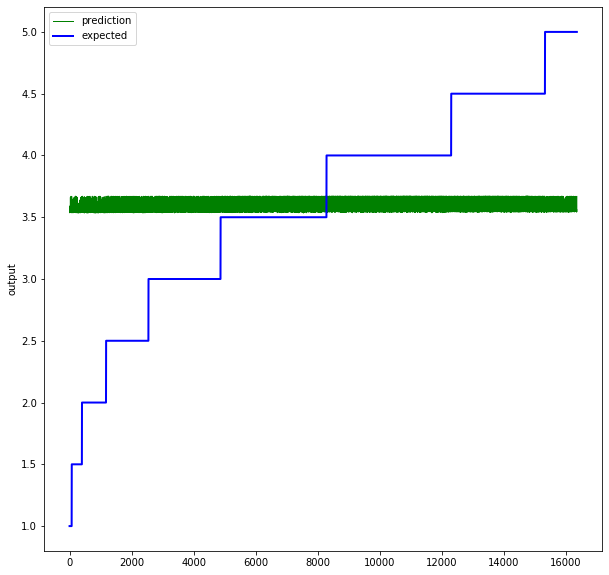

## Model Visuals<a href="#Model-Visuals" class="anchor-link">¶</a>

### Bar Plot<a href="#Bar-Plot" class="anchor-link">¶</a>

In \[141\]:

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    rmses = [a_relu_model_rmse, a_sigmoid_model_rmse, a_tanh_model_rmse, s_relu_model_rmse, s_sigmoid_model_rmse, s_tanh_model_rmse]
    ax.bar(['ReLu', 'Sigmoid', 'Tanh', 'ReLu SGD', 'Sigmoid SGD', 'Tanh SGD'], rmses)
    plt.show()

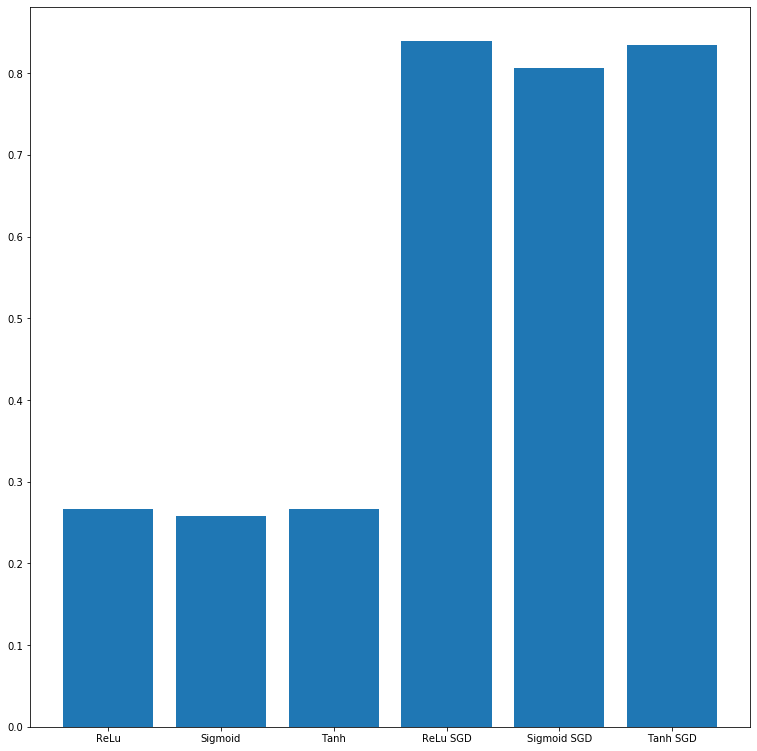

## Using Best Model on Other Dataframes<a href="#Using-Best-Model-on-Other-Dataframes" class="anchor-link">¶</a>

Implementing the best model (Sigmoid, Adam) on other two dataframes we
created.

### Businesses With No Review Count Column<a href="#Businesses-With-No-Review-Count-Column" class="anchor-link">¶</a>

In \[142\]:

    # Save best model with best weights
    checkpointer = ModelCheckpoint(filepath="best_adam_sigmoid_model_1.hdf5", verbose=0, save_best_only=True)

    # Run model training three times to jump out of local optimum
    for i in range(3):
        print('\nRun: ', i + 1)

        sigmoid_model = Sequential()

        sigmoid_model.add(Dense(40, input_dim=x2_train.shape[1], activation='sigmoid'))
        sigmoid_model.add(Dense(20, activation='sigmoid'))
        sigmoid_model.add(Dense(15, activation='sigmoid'))
        sigmoid_model.add(Dense(5, activation='sigmoid'))

        sigmoid_model.add(Dense(1))

        # Use MSE loss since it is a regression problem
        sigmoid_model.compile(loss='mean_squared_error', optimizer='adam')

        # Stop training when model stops improving
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

        sigmoid_model.fit(x2_train, y2_train, validation_data=(x2_test, y2_test), 
                          callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

    Run:  1
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 19s - loss: 2.7753 - val_loss: 0.7057
    Epoch 2/1000
    38168/38168 - 14s - loss: 0.6738 - val_loss: 0.7052
    Epoch 3/1000
    38168/38168 - 14s - loss: 0.6738 - val_loss: 0.7050
    Epoch 4/1000
    38168/38168 - 14s - loss: 0.6736 - val_loss: 0.7048
    Epoch 5/1000
    38168/38168 - 23s - loss: 0.4296 - val_loss: 0.0983
    Epoch 6/1000
    38168/38168 - 18s - loss: 0.0758 - val_loss: 0.0692
    Epoch 7/1000
    38168/38168 - 21s - loss: 0.0623 - val_loss: 0.0656
    Epoch 8/1000
    38168/38168 - 17s - loss: 0.0580 - val_loss: 0.0642
    Epoch 9/1000
    38168/38168 - 15s - loss: 0.0550 - val_loss: 0.0643
    Epoch 10/1000
    38168/38168 - 19s - loss: 0.0530 - val_loss: 0.0643
    Epoch 11/1000
    38168/38168 - 15s - loss: 0.0513 - val_loss: 0.0645
    Epoch 00011: early stopping

    Run:  2
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 17s - loss: 2.1378 - val_loss: 0.7052
    Epoch 2/1000
    38168/38168 - 14s - loss: 0.6738 - val_loss: 0.7050
    Epoch 3/1000
    38168/38168 - 14s - loss: 0.6737 - val_loss: 0.7048
    Epoch 4/1000
    38168/38168 - 14s - loss: 0.5420 - val_loss: 0.1350
    Epoch 5/1000
    38168/38168 - 14s - loss: 0.0870 - val_loss: 0.0718
    Epoch 6/1000
    38168/38168 - 14s - loss: 0.0644 - val_loss: 0.0669
    Epoch 7/1000
    38168/38168 - 13s - loss: 0.0588 - val_loss: 0.0656
    Epoch 8/1000
    38168/38168 - 15s - loss: 0.0560 - val_loss: 0.0638
    Epoch 9/1000
    38168/38168 - 24s - loss: 0.0538 - val_loss: 0.0645
    Epoch 10/1000
    38168/38168 - 28s - loss: 0.0520 - val_loss: 0.0646
    Epoch 11/1000
    38168/38168 - 21s - loss: 0.0506 - val_loss: 0.0639
    Epoch 00011: early stopping

    Run:  3
    Train on 38168 samples, validate on 16359 samples
    Epoch 1/1000
    38168/38168 - 15s - loss: 2.2590 - val_loss: 0.7050
    Epoch 2/1000
    38168/38168 - 14s - loss: 0.6737 - val_loss: 0.7053
    Epoch 3/1000
    38168/38168 - 14s - loss: 0.6738 - val_loss: 0.7048
    Epoch 4/1000
    38168/38168 - 15s - loss: 0.4851 - val_loss: 0.1154
    Epoch 5/1000
    38168/38168 - 15s - loss: 0.0829 - val_loss: 0.0713
    Epoch 6/1000
    38168/38168 - 15s - loss: 0.0638 - val_loss: 0.0667
    Epoch 7/1000
    38168/38168 - 14s - loss: 0.0584 - val_loss: 0.0642
    Epoch 8/1000
    38168/38168 - 15s - loss: 0.0554 - val_loss: 0.0673
    Epoch 9/1000
    38168/38168 - 16s - loss: 0.0535 - val_loss: 0.0640
    Epoch 10/1000
    38168/38168 - 16s - loss: 0.0517 - val_loss: 0.0636
    Epoch 11/1000
    38168/38168 - 18s - loss: 0.0504 - val_loss: 0.0634
    Epoch 12/1000
    38168/38168 - 17s - loss: 0.0494 - val_loss: 0.0638
    Epoch 13/1000
    38168/38168 - 16s - loss: 0.0483 - val_loss: 0.0643
    Epoch 14/1000
    38168/38168 - 15s - loss: 0.0476 - val_loss: 0.0686
    Epoch 00014: early stopping

In \[143\]:

    saved_a_sigmoid_model = load_model("best_adam_sigmoid_model_1.hdf5")

    # SGD Tanh Model Prediction and MSE
    sigmoid_model_pred = saved_a_sigmoid_model.predict(x2_test)
    a_sigmoid_model_rmse = np.sqrt(metrics.mean_squared_error(sigmoid_model_pred, y2_test))
    print(f'SGD Tanh Model RMSE: {a_sigmoid_model_rmse}')

    SGD Tanh Model RMSE: 0.2518198490142822

### Coffee Businesses<a href="#Coffee-Businesses" class="anchor-link">¶</a>

In \[144\]:

    # Save best model with best weights
    checkpointer = ModelCheckpoint(filepath="best_adam_sigmoid_model_2.hdf5", verbose=0, save_best_only=True)

    # Run model training three times to jump out of local optimum
    for i in range(3):
        print('\nRun: ', i + 1)

        sigmoid_model = Sequential()

        sigmoid_model.add(Dense(40, input_dim=x3_train.shape[1], activation='sigmoid'))
        sigmoid_model.add(Dense(20, activation='sigmoid'))
        sigmoid_model.add(Dense(15, activation='sigmoid'))
        sigmoid_model.add(Dense(5, activation='sigmoid'))

        sigmoid_model.add(Dense(1))

        # Use MSE loss since it is a regression problem
        sigmoid_model.compile(loss='mean_squared_error', optimizer='adam')

        # Stop training when model stops improving
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

        sigmoid_model.fit(x3_train, y3_train, validation_data=(x3_test, y3_test), 
                          callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

    Run:  1
    Train on 2114 samples, validate on 906 samples
    Epoch 1/1000
    2114/2114 - 2s - loss: 6.0127 - val_loss: 4.2259
    Epoch 2/1000
    2114/2114 - 1s - loss: 3.2090 - val_loss: 2.3742
    Epoch 3/1000
    2114/2114 - 1s - loss: 1.9479 - val_loss: 1.5424
    Epoch 4/1000
    2114/2114 - 1s - loss: 1.3699 - val_loss: 1.1428
    Epoch 5/1000
    2114/2114 - 1s - loss: 1.0986 - val_loss: 0.9563
    Epoch 6/1000
    2114/2114 - 1s - loss: 0.9775 - val_loss: 0.8753
    Epoch 7/1000
    2114/2114 - 1s - loss: 0.9266 - val_loss: 0.8412
    Epoch 8/1000
    2114/2114 - 1s - loss: 0.9060 - val_loss: 0.8264
    Epoch 9/1000
    2114/2114 - 1s - loss: 0.8989 - val_loss: 0.8217
    Epoch 10/1000
    2114/2114 - 1s - loss: 0.8968 - val_loss: 0.8199
    Epoch 11/1000
    2114/2114 - 1s - loss: 0.8956 - val_loss: 0.8181
    Epoch 12/1000
    2114/2114 - 1s - loss: 0.8950 - val_loss: 0.8173
    Epoch 13/1000
    2114/2114 - 1s - loss: 0.8940 - val_loss: 0.8158
    Epoch 14/1000
    2114/2114 - 1s - loss: 0.8913 - val_loss: 0.8124
    Epoch 15/1000
    2114/2114 - 1s - loss: 0.8849 - val_loss: 0.8039
    Epoch 16/1000
    2114/2114 - 1s - loss: 0.8696 - val_loss: 0.7851
    Epoch 17/1000
    2114/2114 - 1s - loss: 0.8358 - val_loss: 0.7337
    Epoch 18/1000
    2114/2114 - 1s - loss: 0.7135 - val_loss: 0.5462
    Epoch 19/1000
    2114/2114 - 1s - loss: 0.4584 - val_loss: 0.3198
    Epoch 20/1000
    2114/2114 - 1s - loss: 0.2797 - val_loss: 0.2254
    Epoch 21/1000
    2114/2114 - 1s - loss: 0.1990 - val_loss: 0.1839
    Epoch 22/1000
    2114/2114 - 1s - loss: 0.1582 - val_loss: 0.1629
    Epoch 23/1000
    2114/2114 - 1s - loss: 0.1346 - val_loss: 0.1486
    Epoch 24/1000
    2114/2114 - 1s - loss: 0.1171 - val_loss: 0.1367
    Epoch 25/1000
    2114/2114 - 1s - loss: 0.1040 - val_loss: 0.1273
    Epoch 26/1000
    2114/2114 - 1s - loss: 0.0929 - val_loss: 0.1186
    Epoch 27/1000
    2114/2114 - 1s - loss: 0.0821 - val_loss: 0.1138
    Epoch 28/1000
    2114/2114 - 1s - loss: 0.0744 - val_loss: 0.1074
    Epoch 29/1000
    2114/2114 - 1s - loss: 0.0679 - val_loss: 0.1018
    Epoch 30/1000
    2114/2114 - 1s - loss: 0.0624 - val_loss: 0.0984
    Epoch 31/1000
    2114/2114 - 1s - loss: 0.0566 - val_loss: 0.0951
    Epoch 32/1000
    2114/2114 - 1s - loss: 0.0519 - val_loss: 0.0950
    Epoch 33/1000
    2114/2114 - 1s - loss: 0.0480 - val_loss: 0.0925
    Epoch 34/1000
    2114/2114 - 1s - loss: 0.0453 - val_loss: 0.0878
    Epoch 35/1000
    2114/2114 - 1s - loss: 0.0406 - val_loss: 0.0859
    Epoch 36/1000
    2114/2114 - 1s - loss: 0.0377 - val_loss: 0.0834
    Epoch 37/1000
    2114/2114 - 1s - loss: 0.0343 - val_loss: 0.0813
    Epoch 38/1000
    2114/2114 - 1s - loss: 0.0315 - val_loss: 0.0811
    Epoch 39/1000
    2114/2114 - 1s - loss: 0.0295 - val_loss: 0.0803
    Epoch 40/1000
    2114/2114 - 1s - loss: 0.0270 - val_loss: 0.0779
    Epoch 41/1000
    2114/2114 - 1s - loss: 0.0248 - val_loss: 0.0774
    Epoch 42/1000
    2114/2114 - 1s - loss: 0.0231 - val_loss: 0.0765
    Epoch 43/1000
    2114/2114 - 1s - loss: 0.0215 - val_loss: 0.0779
    Epoch 44/1000
    2114/2114 - 1s - loss: 0.0202 - val_loss: 0.0779
    Epoch 45/1000
    2114/2114 - 1s - loss: 0.0189 - val_loss: 0.0777
    Epoch 00045: early stopping

    Run:  2
    Train on 2114 samples, validate on 906 samples
    Epoch 1/1000
    2114/2114 - 2s - loss: 9.3666 - val_loss: 7.2485
    Epoch 2/1000
    2114/2114 - 1s - loss: 5.8316 - val_loss: 4.6574
    Epoch 3/1000
    2114/2114 - 1s - loss: 3.8967 - val_loss: 3.2163
    Epoch 4/1000
    2114/2114 - 1s - loss: 2.7668 - val_loss: 2.3276
    Epoch 5/1000
    2114/2114 - 1s - loss: 2.0642 - val_loss: 1.7644
    Epoch 6/1000
    2114/2114 - 1s - loss: 1.6129 - val_loss: 1.3954
    Epoch 7/1000
    2114/2114 - 1s - loss: 1.3260 - val_loss: 1.1679
    Epoch 8/1000
    2114/2114 - 1s - loss: 1.1497 - val_loss: 1.0257
    Epoch 9/1000
    2114/2114 - 1s - loss: 1.0386 - val_loss: 0.9350
    Epoch 10/1000
    2114/2114 - 1s - loss: 0.9730 - val_loss: 0.8833
    Epoch 11/1000
    2114/2114 - 1s - loss: 0.9374 - val_loss: 0.8547
    Epoch 12/1000
    2114/2114 - 1s - loss: 0.9170 - val_loss: 0.8383
    Epoch 13/1000
    2114/2114 - 1s - loss: 0.9061 - val_loss: 0.8287
    Epoch 14/1000
    2114/2114 - 1s - loss: 0.9014 - val_loss: 0.8246
    Epoch 15/1000
    2114/2114 - 1s - loss: 0.8984 - val_loss: 0.8215
    Epoch 16/1000
    2114/2114 - 1s - loss: 0.8974 - val_loss: 0.8204
    Epoch 17/1000
    2114/2114 - 1s - loss: 0.8967 - val_loss: 0.8197
    Epoch 18/1000
    2114/2114 - 1s - loss: 0.8965 - val_loss: 0.8193
    Epoch 19/1000
    2114/2114 - 1s - loss: 0.8966 - val_loss: 0.8195
    Epoch 20/1000
    2114/2114 - 1s - loss: 0.8965 - val_loss: 0.8194
    Epoch 21/1000
    2114/2114 - 1s - loss: 0.8965 - val_loss: 0.8192
    Epoch 00021: early stopping

    Run:  3
    Train on 2114 samples, validate on 906 samples
    Epoch 1/1000
    2114/2114 - 3s - loss: 19.5916 - val_loss: 16.5778
    Epoch 2/1000
    2114/2114 - 1s - loss: 14.6142 - val_loss: 13.0478
    Epoch 3/1000
    2114/2114 - 1s - loss: 11.8103 - val_loss: 10.7434
    Epoch 4/1000
    2114/2114 - 1s - loss: 9.7756 - val_loss: 8.9219
    Epoch 5/1000
    2114/2114 - 1s - loss: 8.1615 - val_loss: 7.4907
    Epoch 6/1000
    2114/2114 - 1s - loss: 6.8962 - val_loss: 6.3663
    Epoch 7/1000
    2114/2114 - 1s - loss: 5.8900 - val_loss: 5.4539
    Epoch 8/1000
    2114/2114 - 1s - loss: 5.0689 - val_loss: 4.6993
    Epoch 9/1000
    2114/2114 - 1s - loss: 4.3838 - val_loss: 4.0684
    Epoch 10/1000
    2114/2114 - 1s - loss: 3.8020 - val_loss: 3.5260
    Epoch 11/1000
    2114/2114 - 1s - loss: 3.3136 - val_loss: 3.0712
    Epoch 12/1000
    2114/2114 - 1s - loss: 2.8919 - val_loss: 2.6786
    Epoch 13/1000
    2114/2114 - 1s - loss: 2.5339 - val_loss: 2.3432
    Epoch 14/1000
    2114/2114 - 1s - loss: 2.2315 - val_loss: 2.0644
    Epoch 15/1000
    2114/2114 - 1s - loss: 1.9770 - val_loss: 1.8264
    Epoch 16/1000
    2114/2114 - 1s - loss: 1.7648 - val_loss: 1.6284
    Epoch 17/1000
    2114/2114 - 1s - loss: 1.5869 - val_loss: 1.4634
    Epoch 18/1000
    2114/2114 - 1s - loss: 1.4429 - val_loss: 1.3301
    Epoch 19/1000
    2114/2114 - 1s - loss: 1.3263 - val_loss: 1.2220
    Epoch 20/1000
    2114/2114 - 1s - loss: 1.2312 - val_loss: 1.1344
    Epoch 21/1000
    2114/2114 - 1s - loss: 1.1553 - val_loss: 1.0644
    Epoch 22/1000
    2114/2114 - 1s - loss: 1.0928 - val_loss: 1.0060
    Epoch 23/1000
    2114/2114 - 1s - loss: 1.0444 - val_loss: 0.9609
    Epoch 24/1000
    2114/2114 - 1s - loss: 1.0066 - val_loss: 0.9257
    Epoch 25/1000
    2114/2114 - 1s - loss: 0.9769 - val_loss: 0.8981
    Epoch 26/1000
    2114/2114 - 1s - loss: 0.9538 - val_loss: 0.8761
    Epoch 27/1000
    2114/2114 - 1s - loss: 0.9370 - val_loss: 0.8604
    Epoch 28/1000
    2114/2114 - 1s - loss: 0.9257 - val_loss: 0.8494
    Epoch 29/1000
    2114/2114 - 1s - loss: 0.9165 - val_loss: 0.8413
    Epoch 30/1000
    2114/2114 - 1s - loss: 0.9099 - val_loss: 0.8341
    Epoch 31/1000
    2114/2114 - 1s - loss: 0.9060 - val_loss: 0.8302
    Epoch 32/1000
    2114/2114 - 1s - loss: 0.9028 - val_loss: 0.8270
    Epoch 33/1000
    2114/2114 - 1s - loss: 0.9006 - val_loss: 0.8248
    Epoch 34/1000
    2114/2114 - 1s - loss: 0.8993 - val_loss: 0.8232
    Epoch 35/1000
    2114/2114 - 1s - loss: 0.8981 - val_loss: 0.8218
    Epoch 36/1000
    2114/2114 - 1s - loss: 0.8973 - val_loss: 0.8208
    Epoch 37/1000
    2114/2114 - 1s - loss: 0.8969 - val_loss: 0.8202
    Epoch 38/1000
    2114/2114 - 1s - loss: 0.8967 - val_loss: 0.8199
    Epoch 39/1000
    2114/2114 - 1s - loss: 0.8966 - val_loss: 0.8195
    Epoch 40/1000
    2114/2114 - 1s - loss: 0.8965 - val_loss: 0.8194
    Epoch 41/1000
    2114/2114 - 1s - loss: 0.8966 - val_loss: 0.8194
    Epoch 42/1000
    2114/2114 - 1s - loss: 0.8964 - val_loss: 0.8191
    Epoch 43/1000
    2114/2114 - 1s - loss: 0.8964 - val_loss: 0.8191
    Epoch 44/1000
    2114/2114 - 1s - loss: 0.8965 - val_loss: 0.8189
    Epoch 45/1000
    2114/2114 - 1s - loss: 0.8964 - val_loss: 0.8190
    Epoch 46/1000
    2114/2114 - 1s - loss: 0.8965 - val_loss: 0.8191
    Epoch 47/1000
    2114/2114 - 1s - loss: 0.8965 - val_loss: 0.8192
    Epoch 00047: early stopping

In \[145\]:

    saved_a_sigmoid_model = load_model("best_adam_sigmoid_model_2.hdf5")

    # SGD Tanh Model Prediction and MSE
    sigmoid_model_pred = saved_a_sigmoid_model.predict(x3_test)
    a_sigmoid_model_rmse = np.sqrt(metrics.mean_squared_error(sigmoid_model_pred, y3_test))
    print(f'SGD Tanh Model RMSE: {a_sigmoid_model_rmse}')

    SGD Tanh Model RMSE: 0.27662813663482666

## Using Best Model to Predict<a href="#Using-Best-Model-to-Predict" class="anchor-link">¶</a>

In \[149\]:

    x_train, x_test, y_train, y_test = train_test_split(
        df_b1[['business_id', 'name', 'category']], train1['business_stars'], test_size=0.3, random_state=19)


    predict = pd.DataFrame(sigmoid_model_pred, columns = ['Prediction'])
    x_test_df = pd.DataFrame(x_test).sort_index().reset_index()
    y_test_true = y_test.reset_index()

    result = pd.concat([x_test_df, y_test_true, predict], axis=1)
    result.drop(['business_id', 'index'], axis=1, inplace=True)


    # 5 arbitrary businesses from test dataset true stars and predicted stars
    df_compare = pd.DataFrame(result.loc[[2,10,27,235,1100]])
    df_compare

Out\[149\]:

|      | name                  | category                                          | business_stars | Prediction |
|------|-----------------------|---------------------------------------------------|----------------|------------|
| 2    | Impressions Dental    | Cosmetic Dentists, Dentists, Oral Surgeons, He... | 5.0            | 4.497715   |
| 10   | Ted Wiens Tire & Auto | Oil Change Stations, Tires, Automotive, Auto R... | 4.5            | 4.346560   |
| 27   | London Pub Company    | Nightlife, Bars, Pubs                             | 4.0            | 3.886738   |
| 235  | Sonic Drive-In        | Ice Cream & Frozen Yogurt, Food, Fast Food, Bu... | 3.0            | 4.233273   |
| 1100 | Nothing Bundt Cakes   | Bakeries, Food, Cupcakes, Desserts                | 3.5            | NaN        |

In \[ \]: